# CoastSat.Venice

This example shows users how to use the CoastSat toolbox to extract time-series of shoreline change at an individual beach. This notebook was edited by A. Rovere, Ca'Foscari University of Venice, from the original CoastSat repository. 

**Even if you use this modified version of CoastSat, please cite and give credit to the original authors and cite their papers below!!!!!**

The main changes are related to the calculateion of tides, which is done in CoastSat with pyfes and here is done with pyTMD, which is less problematic in terms of setup.


In this notebook, we use CoastSat and CoastSat.Slope to assess the beach stability over time and the slope of the modern beach at Bahia Laura, a bay in Patagonia. As it is setup, the script downloads a large amount of data, so make sure you have enough space on your hard drive and a good internet connection.

The software is described in details in the following publications: 

> Vos, K., Splinter, K. D., Harley, M. D., Simmons, J. A., & Turner, I. L. (2019). CoastSat: A Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. Environmental Modelling & Software, 122, 104528.

> Vos, K., Harley, M. D., Splinter, K. D., Walker, A., & Turner, I. L. (2020). Beach slopes from satellite‐derived shorelines. Geophysical Research Letters, 47(14), e2020GL088365.

The following code has been adapted from the example files in CoastSat and CoastSat.Slope

The last 3 sections, 5 and 6, use long-term Landsat satellite-derived shorelines to demonstrate how to post-process the time-series (despiking, seasonal averaging), beach slope estimation and validations of the accuracy of the satellite-derived shorelines.

This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

**Contents:**
* [1.1 Initial settings](#initial-settings)
* [1.2 Retrieval of the images from GEE](#GEE-retrieval)
* [1.3 Shoreline extraction](#shoreline-extraction)
* [1.3.1 Digitize a reference shoreline](#ref-shoreline)
* [1.3.2 Batch shoreline detection](#batch-shoreline)
* [1.4 Shoreline analysis](#shoreline-analysis)
* [1.5 Water level extraction](#tidal)
* [1.6 Beach slope estimation](#slope)


## Initial settings <a class="anchor" id="initial-settings"></a>

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [25]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects,SDS_slope

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import ee
ee.Authenticate()

True

## Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

To create you ROI polygon, go to [geojson.io](https://geojson.io), draw a polygon for your area of interest and export it as a GeoJSON and then read it with the function `SDS_tools.polygon_from_geojson()`.

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

For Landsat, users can also choose between Collection 1 and Collection 2 with the `collection` variable. Note that from 1st Jan 2022 newly acquired Landsat images are only available in Collection 2, with Landsat 9 only available in Collection 2, so it's preferred that you use Collection 2.

For Sentinel-2, if you know in which tile your ROI is located you can specify the tile, for example `inputs['S2tile'] = '56HLH'` for the tile covering Sydney. You can view Sentinel-2 tiles [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59). By specifying the tile you can avoid issues with a lot of duplicates from multiple tiles.

Remember to Select the spatial reference system in which to output the coordinates of the mapped shorelines. See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates** (eastings and northings) and **not spherical coordinates** (lat,lon like WGS84). It is important that you use a local projection otherwise you may introduce errors when intersecting the shorelines with the cross-shore transects.

In [3]:
# load from .geojson
geojson_polygon = os.path.join(os.getcwd(), 'Data', 'BHL.geojson')
polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

# date range
dates = ['1988-01-01', '2024-01-01']

# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L5','L7','L8','L9','S2']

# name of the site
sitename = 'Bahia_Laura'

# EPSG
EPSG=3857

# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'Data')

# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list,
          'sitename': sitename, 'filepath':filepath}

# optionally, you can select your Sentinel-2 tile to avoid duplicates from multiple tiles
# inputs['S2tile'] = '56HLH'
# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 1988-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 166 images
     L7: 732 images
     L8: 211 images
     L9: 41 images
     S2: 381 images
  Total to download: 1531 images
L5: 166 images already exist, 0 to download
L7: 732 images already exist, 59 to download
L8: 211 images already exist, 0 to download
L9: 41 images already exist, 0 to download
S2: 381 images already exist, 0 to download
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 59 images
     L7: 75 images
     L8: 9 images
  Total Tier 2: 143 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

You can decide to skip the Landsat 7 images affected by the May 2003 Scan-Line-Corrector issue by settings `inputs['skip_L7_SLC'] = True`, although this is not recommended as L7 images can still be processed with the gaps.

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images()`.

In [ ]:
# option to skip L7 images affected by the Scan-Line-Correction error after 31st May 2003
#inputs['skip_L7_SLC'] = True
# option to include Tier 2 images (ONLY IF NO OTHER IMAGES ARE AVAILABLE)
# inputs['include_T2'] = True

In [ ]:
metadata = SDS_download.retrieve_images(inputs)

**If you have already retrieved the images**, just load the metadata file by only running the section below

In [4]:
metadata = SDS_download.get_metadata(inputs)

## Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README file of the Github repository.

In [5]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': EPSG,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

In [6]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L5: 166 images
100%
L7: 673 images
100%
L8: 211 images
100%
L9: 41 images
100%
S2: 381 images
100%
Satellite images saved as .jpg in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/jpg_files/preprocessed


In [ ]:
# create timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_RGB.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'preprocessed')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

### Digitize a reference shoreline [HIGHLY RECOMMENDED] <a class="anchor" id="ref-shoreline"></a>
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [7]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded
Reference shoreline coordinates are in epsg:3857


### Batch shoreline detection <a class="anchor" id="batch-shoreline"></a>

Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [8]:
# to skip manually checking each image, uncomment below
settings['check_detection'] = False

In [9]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L5:   100%
L7:   46%Could not map shoreline for this image: 2014-02-01-13-51-40_L7_226094_Bahia_Laura_ms.tif
L7:   100%
L8:   100%
L9:   100%
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [10]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

48 duplicates
4 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [11]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
fp_geojson = os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype))
gdf.to_file(fp_geojson,driver='GeoJSON', encoding='utf-8')
print('Saved spatial layer at %s'%fp_geojson)

Saved spatial layer at /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/Bahia_Laura_output_lines.geojson


Again, we can create a timelapse animation showing the movement of the shoreline:

In [12]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_shorelines.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'detection')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

Animation has been generated (using 4 frames per second) and saved at /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/Bahia_Laura_animation_shorelines.gif


Simple plot of the mapped shorelines. The coordinates are stored in the output dictionary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

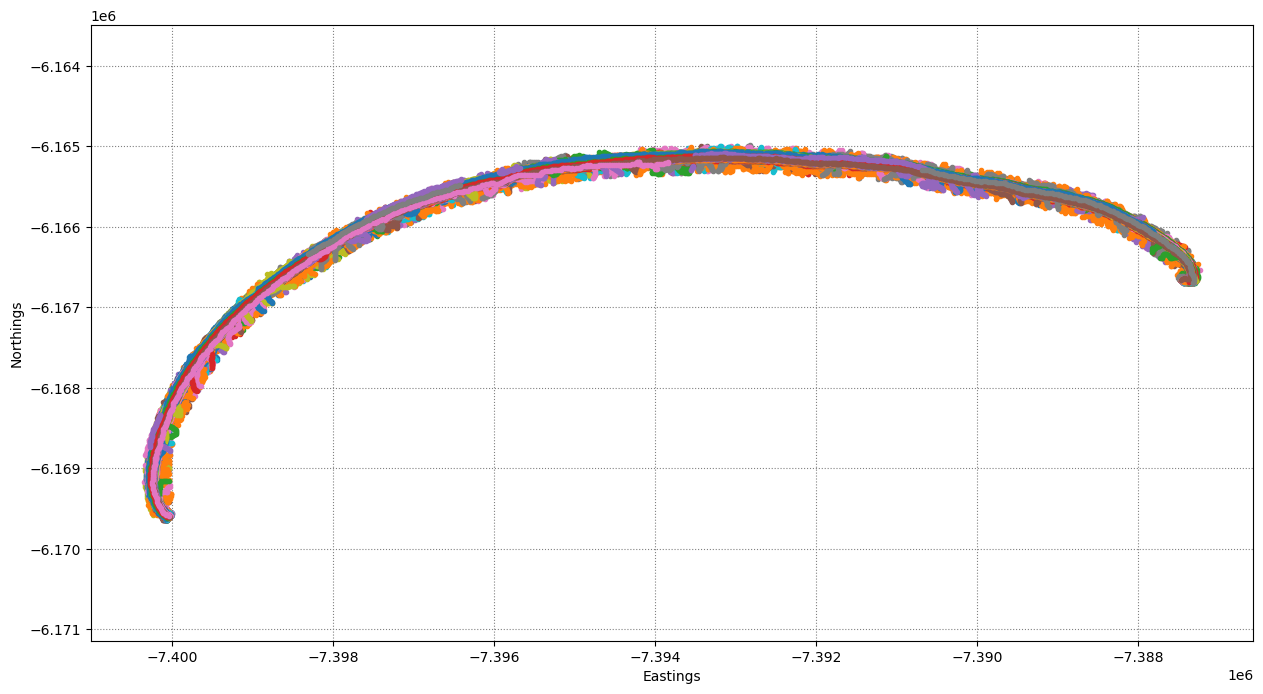

In [13]:
%matplotlib inline 
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.show()
# plt.legend();

## Shoreline analysis <a class="anchor" id="shoreline-analysis"></a>

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [90]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

48 duplicates
4 bad georef


There are 2 options to define the coordinates of the shore-normal transects:

**Option 1**: the user can interactively draw the shore-normal transects along the beach by calling:

In [18]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura


**Option 2**: the user can load the transect coordinates (make sure the coordinate reference system (CRS) is the same as defined previously in `settings['output_epsg]`) from a .geojson file by calling:

In [19]:
#geojson_file = os.path.join(os.getcwd(), 'Data', sitename+'.geojson')
#transects = SDS_tools.transects_from_geojson(geojson_file)

Plot the location of the transects, make sure they are in the right location with the origin always landwards! Also check that the transects are intersecting the mapped shorelines.

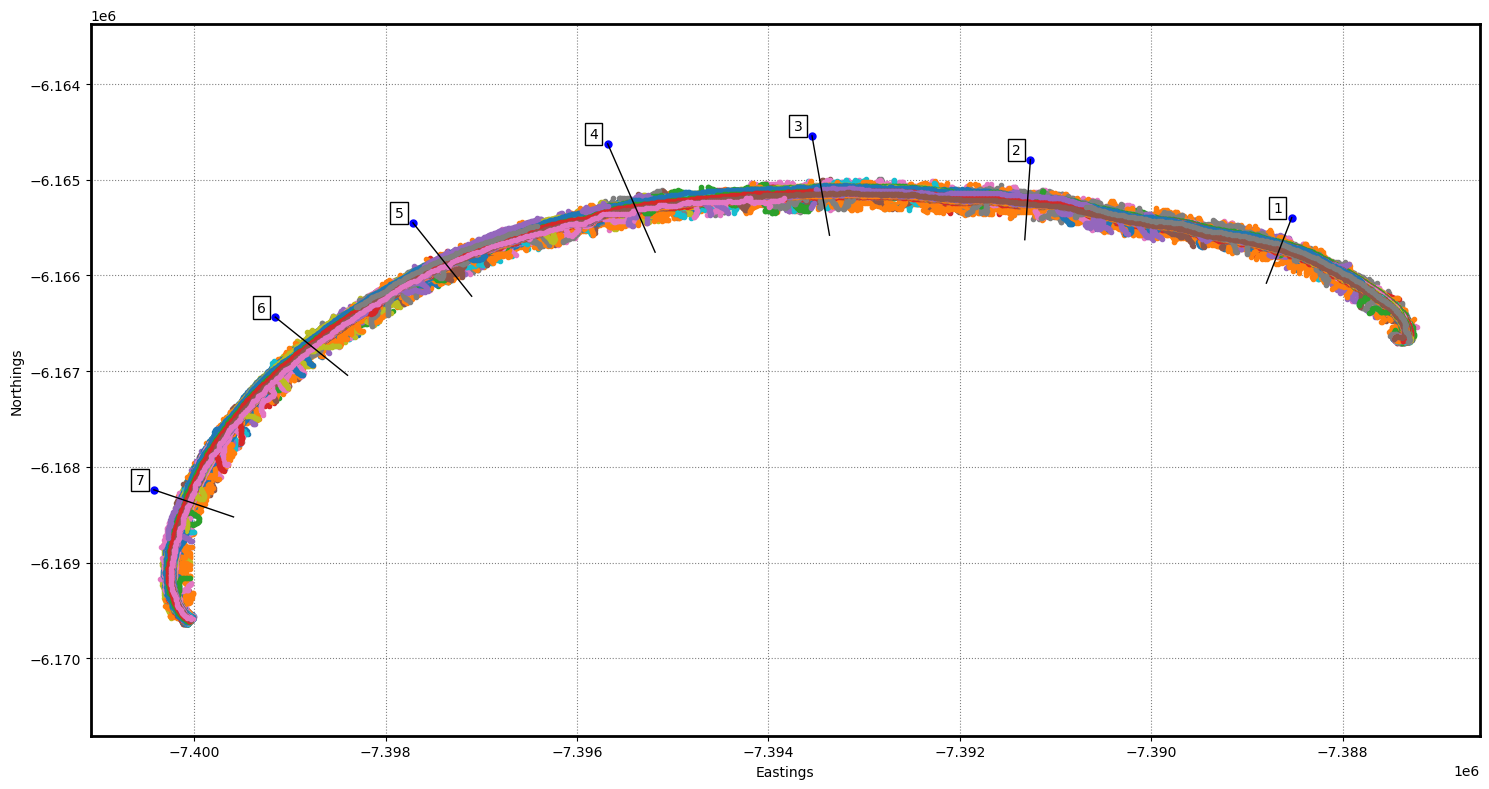

In [91]:
%matplotlib inline 
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig.savefig(os.path.join(filepath,'%s_mapped_shorelines.jpg'%sitename),dpi=200)
plt.show()

Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect. The shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [148]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

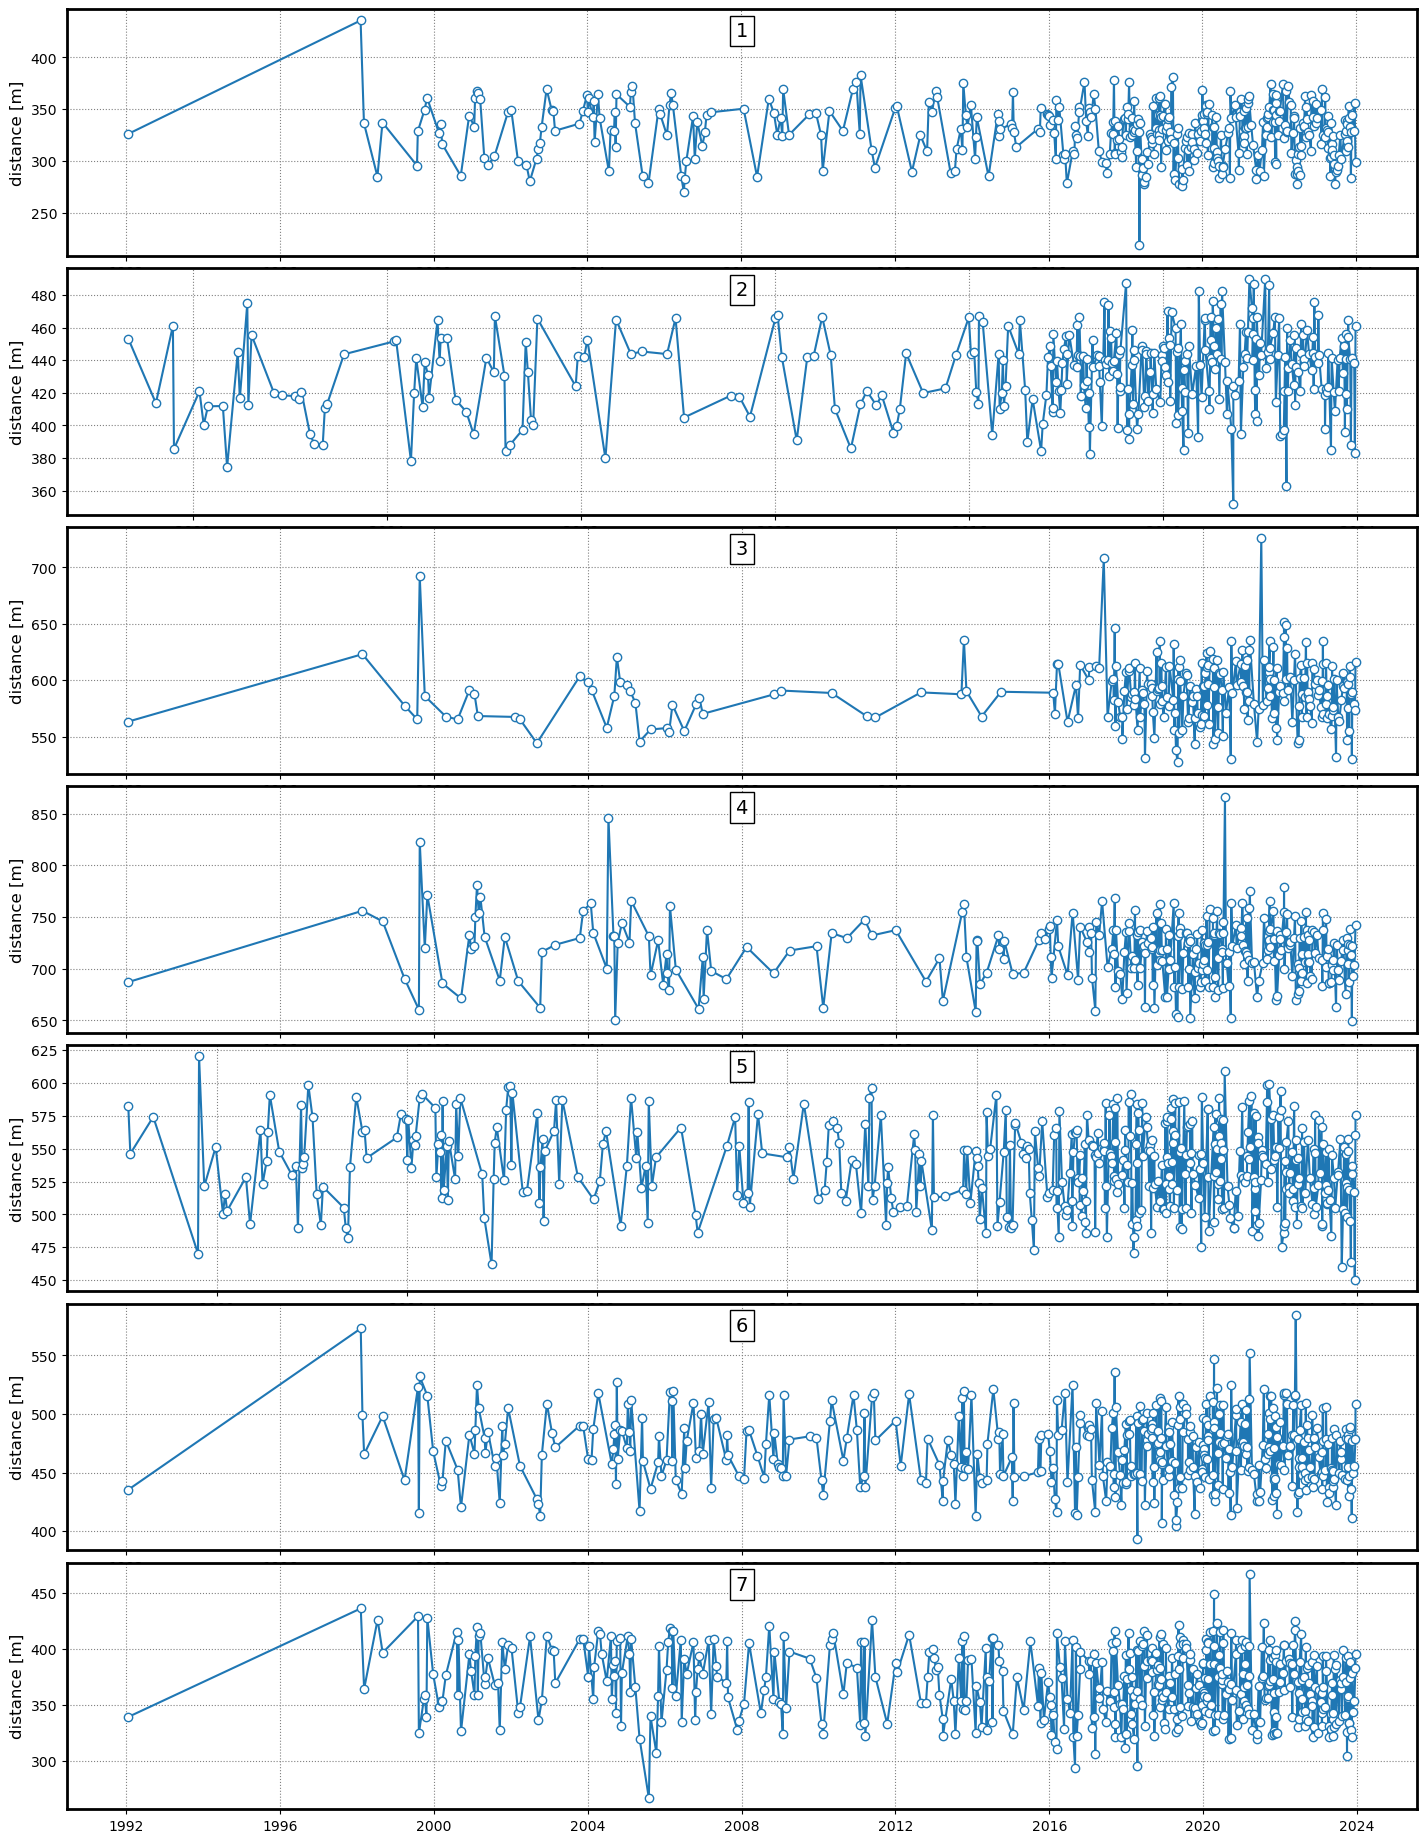

In [149]:
%matplotlib inline
fig = plt.figure(figsize=[15,20], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
fig.savefig(os.path.join(filepath,'%s_timeseries_raw.jpg'%sitename),dpi=200)
plt.show()

In [150]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(filepath,'%s_time_series_raw.csv'%sitename)
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
/Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/Bahia_Laura_time_series_raw.csv


##  Water level extraction <a class="anchor" id="tides"></a>

In this section, we make tidal predictions using the FES2014 software. The tidal predictions are then used to estimate the beach slope and to correct the time series. This is where CoastSat.-Venice differs most from the original version of CoastSat, as we use pyTMD instead of pyfes. Eventually, pyTMD might also allow the use of other tide prediction software, such as OSU.

In [26]:
# Insert the folder where the data is located and the coordinates at which you want to extrapolate the tidal data
folder='TidalModel/FES_2014/aviso-fes-main/data/'
LAT=45.395015
LON=12.362590

# insert the version of FES you are using
MODEL_NAME='FES2014'

# Use the first and last date in the list
start_date = dates[0] - timedelta(days=60)  # sixty days before the start date
end_date = dates[-1] + timedelta(days=60)   # sitty days after the end date

# Time interval for water level extraction
interval_tide = 30 #minutes

This cell calculates tides for the area of interest. Depending on how long the time period is, it may take a long time.

In [27]:
from astropy.time import Time, TimeDelta
import pandas as pd
import datetime
import pyTMD
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import os
import numpy as np
import timescale.time

current_path = os.getcwd()
full_path = os.path.join(current_path, folder)
model = pyTMD.io.model(full_path,format='netcdf',compressed=False).elevation(MODEL_NAME)

# Calculate the total number of 10-minute intervals between start and end dates
total_minutes = int((end_date - start_date).total_seconds() // 60)
interval_minutes = interval_tide
minutes = np.arange(0, total_minutes + interval_minutes, interval_minutes)

# Set the base date YMD to the start date
YMD = start_date.date()  # Using only the date part
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
ts = timescale.time.Timescale().from_calendar(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

constituents = pyTMD.io.FES.read_constants(model.model_file,
                                           type=model.type, version=model.version,
                                           compressed=model.compressed)
c = model.constituents
# delta time (TT - UT1)
DELTAT = ts.tt_ut1

amp,ph = pyTMD.io.FES.interpolate_constants(np.atleast_1d(LON), np.atleast_1d(LAT),
                                            constituents, scale=model.scale,
                                            method='spline', extrapolate=True)

# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)
# predict tidal elevations at time and infer minor corrections
TIDE = pyTMD.predict.time_series(ts.tide, hc, c,
                                 deltat=DELTAT, corrections=model.corrections)
MINOR = pyTMD.predict.infer_minor(ts.tide, hc, c,
                                  deltat=DELTAT, corrections=model.corrections)
TIDE.data[:] += MINOR.data[:]

# Convert `ts` to a readable datetime format if it's not already
base_mjd = Time(YMD.isoformat(), format='iso', scale='utc').mjd  # MJD 
# Add minutes to your base MJD, converting minutes to days
mjd_times = base_mjd + (minutes / (24 * 60))  # Convert minutes to days
# Convert MJD to datetime for plotting
calendar_dates = Time(mjd_times, format='mjd', scale='utc').to_datetime()

# Create a DataFrame with the time and tide data
tides_df = pd.DataFrame({
    'DateTime': calendar_dates,
    'Tide': TIDE.data
})

The tidal values are saved in a .csv file.

In [28]:
tides_df = pd.DataFrame({'Calendar Date (UTC)': calendar_dates,'TIDE_data': TIDE.data})
# Format the date column
tides_df['dates'] = pd.to_datetime(tides_df['Calendar Date (UTC)']).dt.strftime('%Y-%m-%d %H:%M:%S.%f+00:00')
# Format the tide column to 3 decimal places
tides_df['tide'] = tides_df['TIDE_data'].round(3)
tides_df.drop(columns=['Calendar Date (UTC)','TIDE_data'],inplace=True)

csvname = os.path.join(filepath,'tides.csv')
tides_df.to_csv(csvname, index=False)
print('Tide csv file saved in the project folder')

Tide csv file saved in the project folder


Tides and satellite times are compared and the closest water levels to the satellite image acquisition time are calculated.

In [32]:
dates_sat = output['dates']

# load the measured tide data
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tides_df['dates']]
tides_ts = np.array(tides_df['tide'])

# get tide levels corresponding to the time of image acquisition
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

Extracting closest points: 100%

Everything is plotted together. Plotting can take a long time, but it helps checking the data.

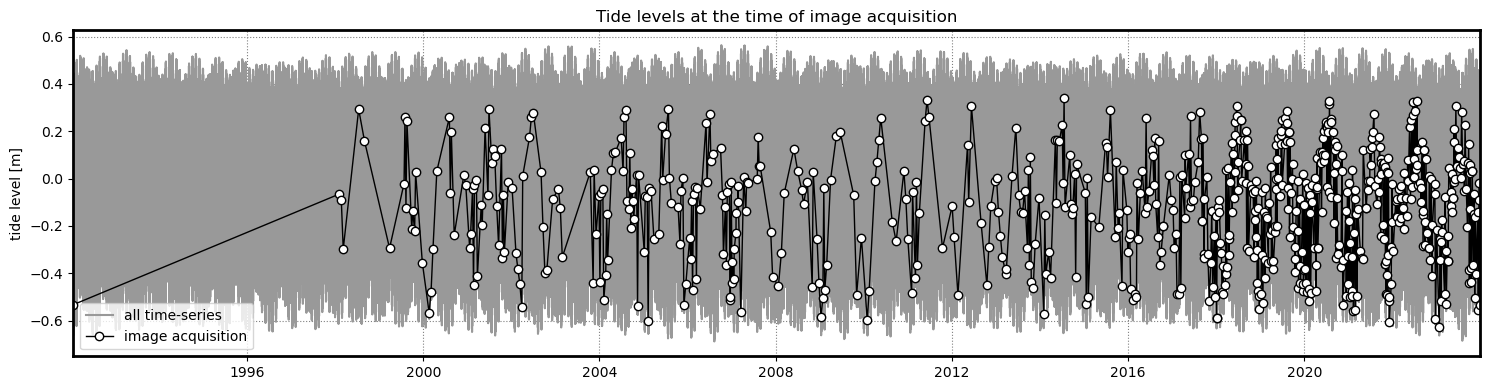

In [36]:
%matplotlib inline
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
fig.savefig(os.path.join(filepath,'%s_tide_timeseries.jpg'%sitename),dpi=200)
plt.show()

## Beach slope estimation

**Satellite-derived shorelines from Landsat 5, 7 and 8 between 1999 and 2020 are needed to estimate the beach slope**, these have to be mapped with CoastSat beforehand. When mapping shorelines with CoastSat, the coordinates of the 2D shorelines are saved in a file named `sitename_output.pkl`. When preparing your own files, make sure that both files are in the same coordinate system.

The section below loads the two files, removes duplicates and shorelines with poor georeferencing and plots the 2D shorelines and cross-shore transects.

More details on the slope estimation methodology are [Vos et al. 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL088365) and [Vos et al. 2022](https://essd.copernicus.org/articles/14/1345/2022/). 

For a more detailed tutorial visit the [CoastSat.slope repository](https://github.com/kvos/CoastSat.slope/tree/master).

In [151]:
# create folder to save outputs from slope estimation
fp_slopes = os.path.join(filepath,'slope_estimation')
if not os.path.exists(fp_slopes):
    os.makedirs(fp_slopes)
print('Outputs will be saved in %s'%fp_slopes)

import copy
# Make a deep copy of cross_distance
cross_distance_slope = copy.deepcopy(cross_distance)

Outputs will be saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/slope_estimation


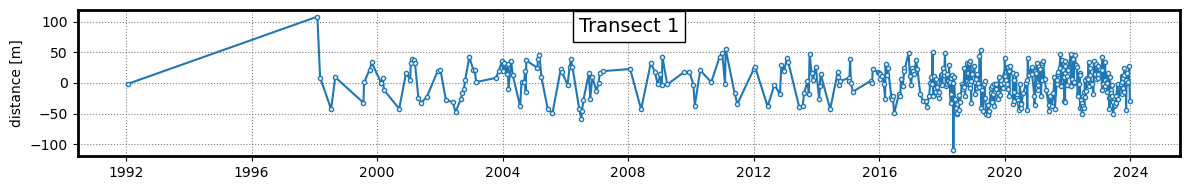

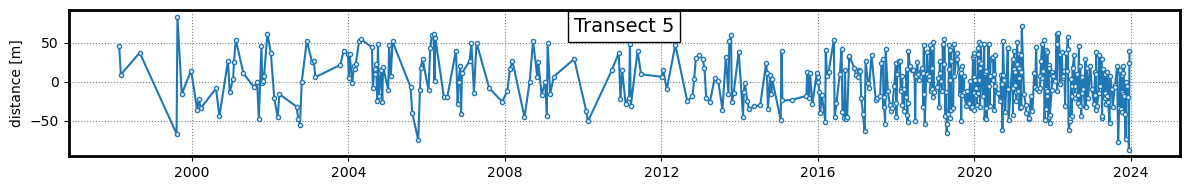

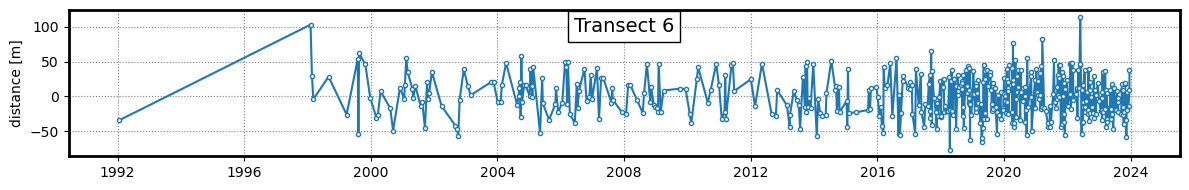

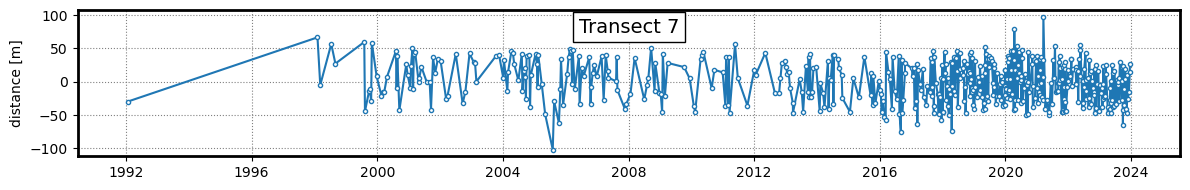

Length of cross_distance[7]: 708


In [152]:
%matplotlib inline
# plot time-series
SDS_slope.plot_cross_distance(output['dates'],cross_distance_slope)
plt.show()

In [153]:
# slope estimation settings
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.035,                  # minimum slope to trial
                  'slope_max':        0.2,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freq_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  'prc_conf':         0.05,                   # percentage above minimum to define confidence bands in energy curve
                  'plot_fig':         True,                   # whether to plot the intermediary products during analysis
                  }
# range of slopes to test for
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

Length of cross_distance[7]: 708


In [155]:
# range of dates over which to perform the analysis (2 Landsat satellites)
settings_slope['date_range'] = [1999,2024]
# re-write in datetime objects (same as shoreline in UTC)
settings_slope['date_range'] = [pytz.utc.localize(datetime.datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime.datetime(settings_slope['date_range'][1],1,1))]

# clip the time-series between 1999 and 2024 as we need at least 2 Landsat satellites 
idx_dates = [np.logical_and(_>settings_slope['date_range'][0],_<settings_slope['date_range'][1]) for _ in output['dates']]
dates_slope = [output['dates'][_] for _ in np.where(idx_dates)[0]]

for key in cross_distance_slope.keys():
    cross_distance_slope[key] = cross_distance_slope[key][idx_dates]
    
tides_slope = SDS_tools.get_closest_datapoint(dates_slope, dates_ts, tides_ts)

Extracting closest points: 100%

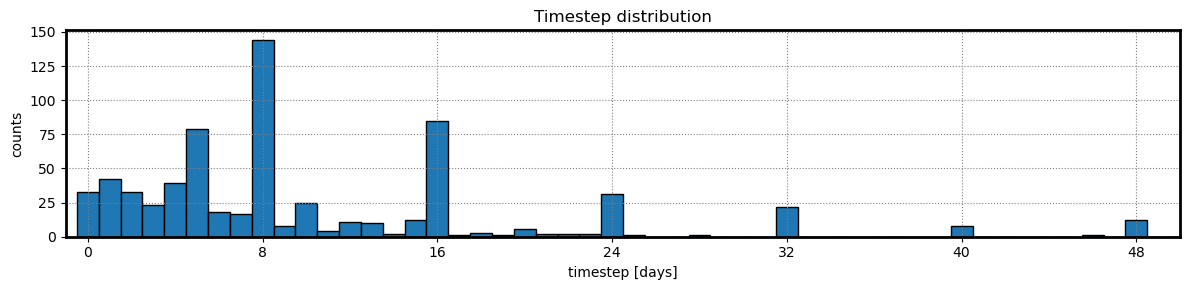

In [156]:
SDS_slope.plot_timestep(dates_slope)
plt.gcf().savefig(os.path.join(fp_slopes,'0_timestep_distribution.jpg'),dpi=200)
plt.show()

In [157]:
# sampling period [days]
settings_slope['n_days'] = 8

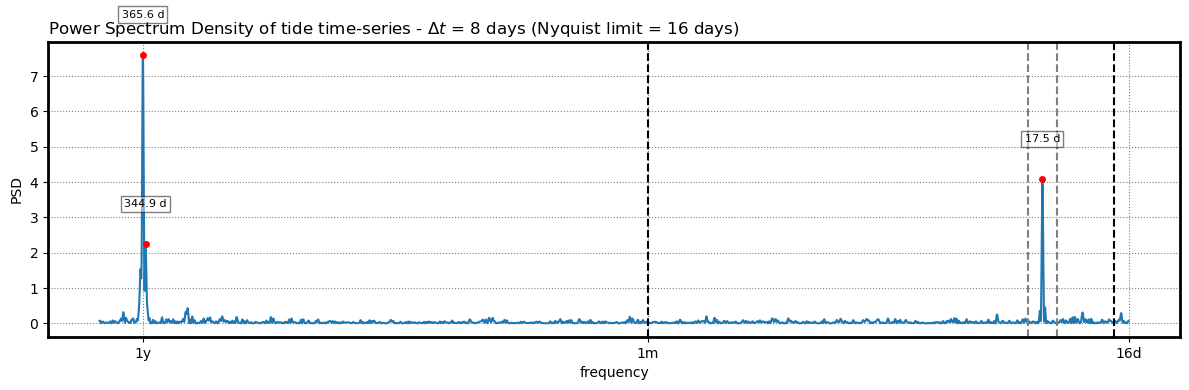

In [158]:
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(dates_slope,tides_slope,settings_slope)
plt.gcf().savefig(os.path.join(fp_slopes,'1_tides_power_spectrum.jpg'),dpi=200)
plt.show()

Beach slope at transect 1: 0.200 (0.1325 - 0.2000)
Beach slope at transect 2: 0.200 (0.1275 - 0.2000)
Beach slope at transect 3: 0.200 (0.0700 - 0.2000)
Beach slope at transect 4: 0.200 (0.1025 - 0.2000)
Beach slope at transect 5: 0.200 (0.0950 - 0.2000)
Beach slope at transect 6: 0.200 (0.1075 - 0.2000)
Beach slope at transect 7: 0.200 (0.1050 - 0.2000)


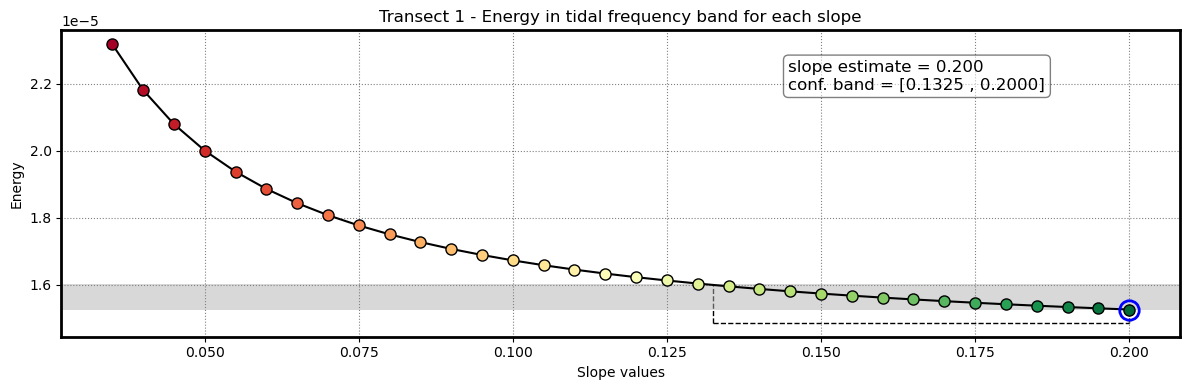

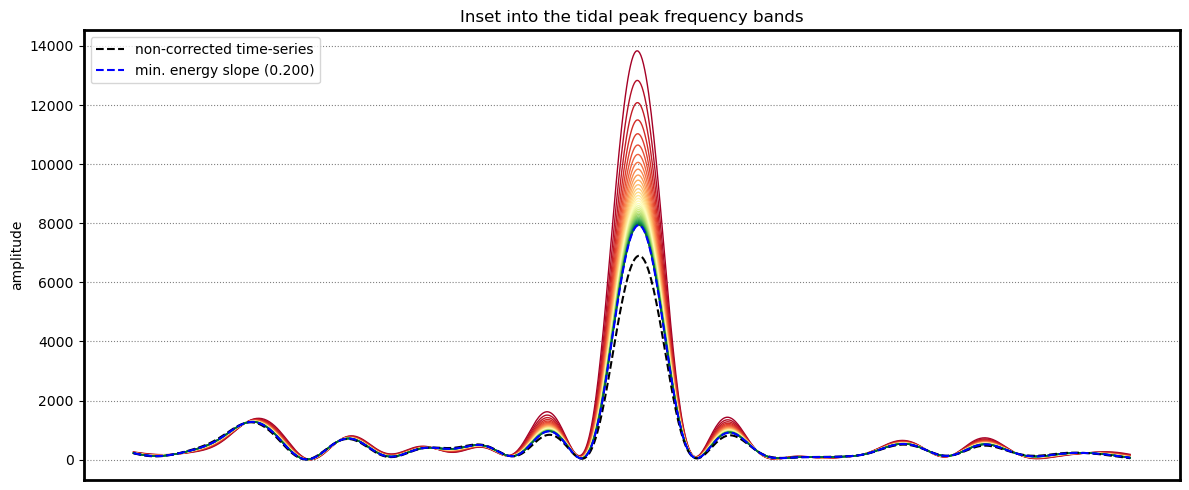

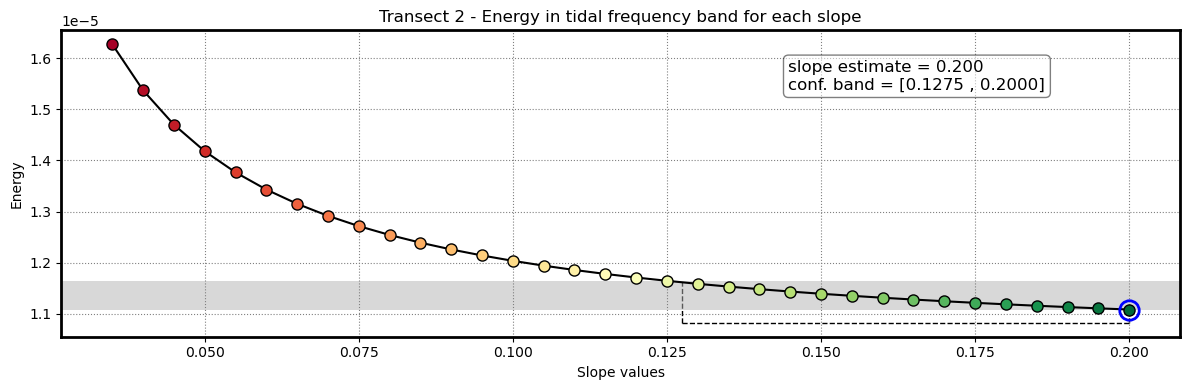

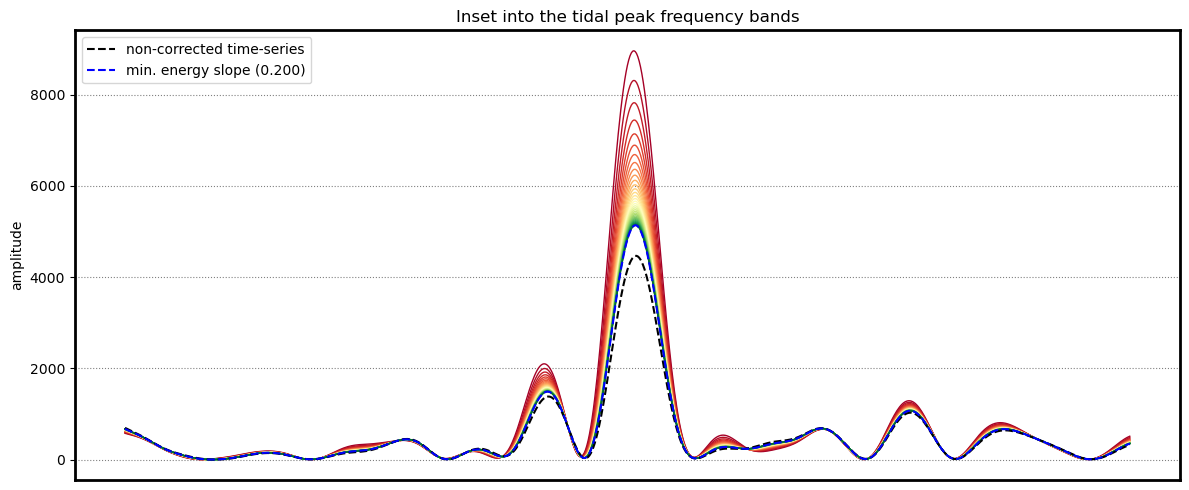

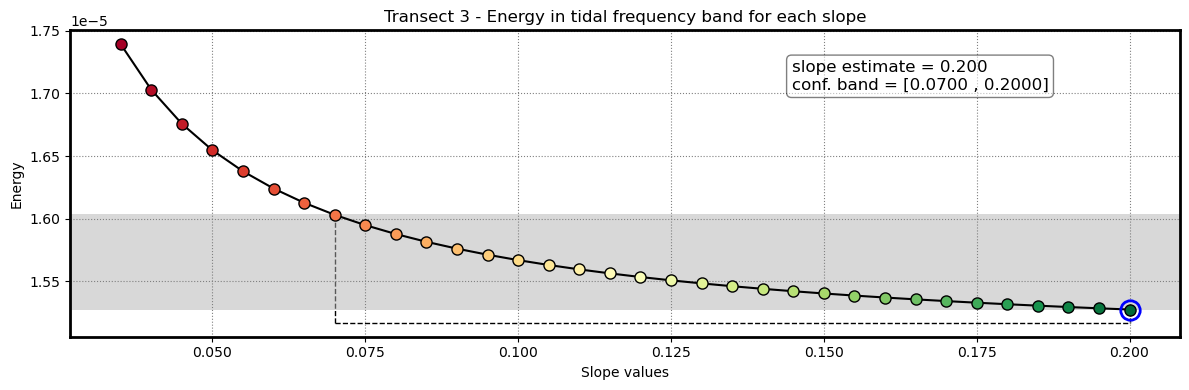

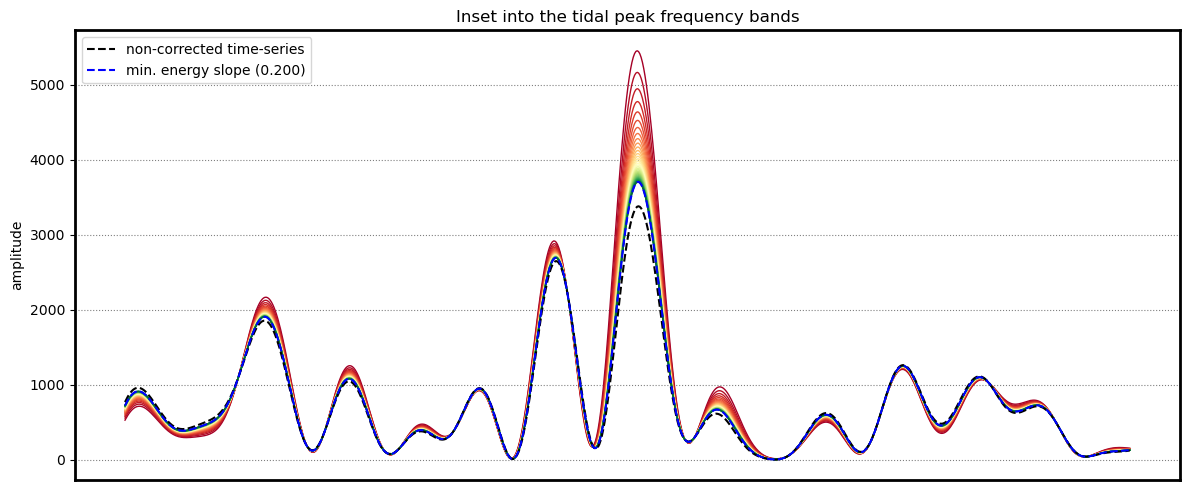

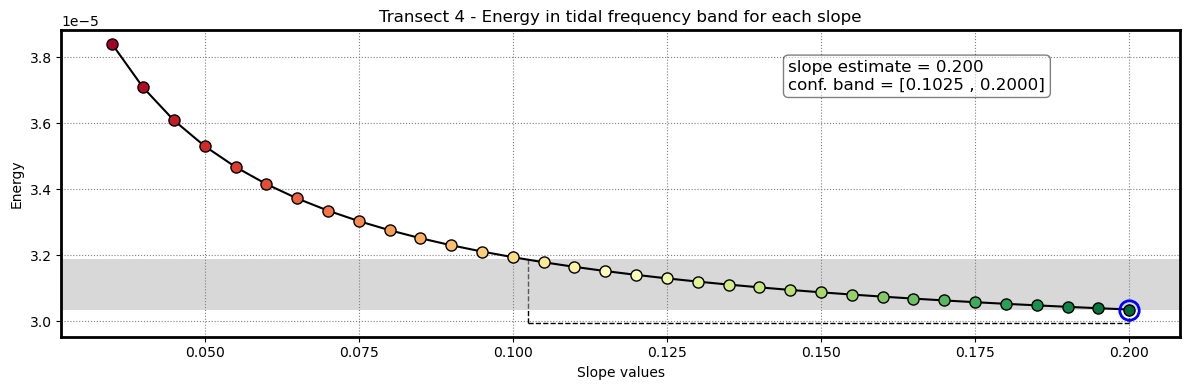

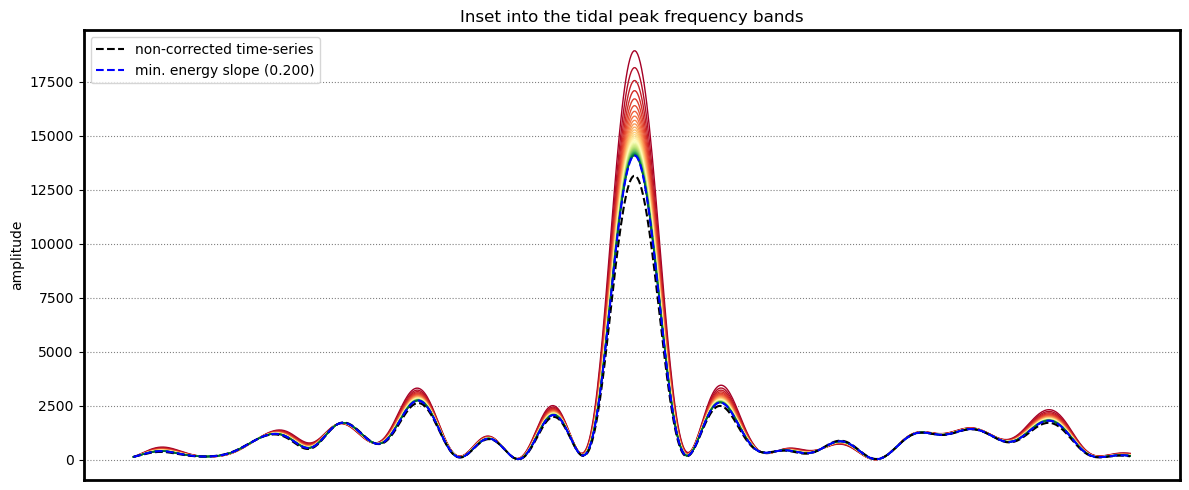

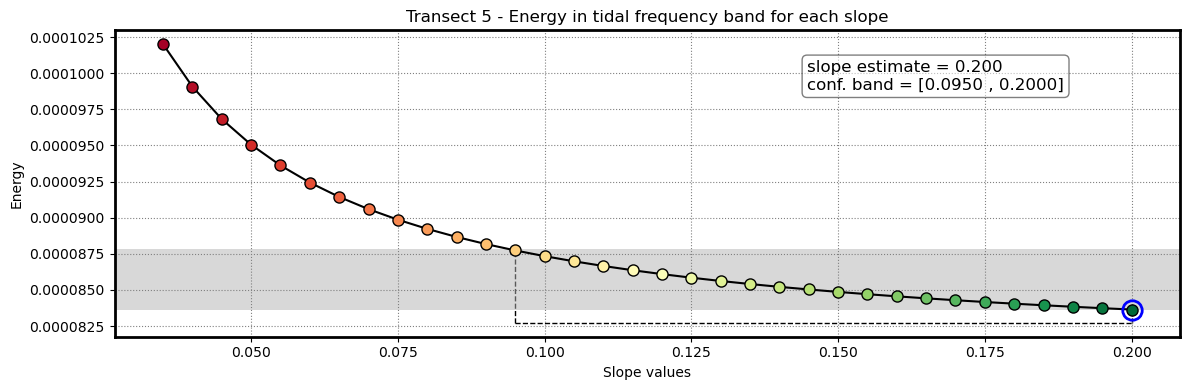

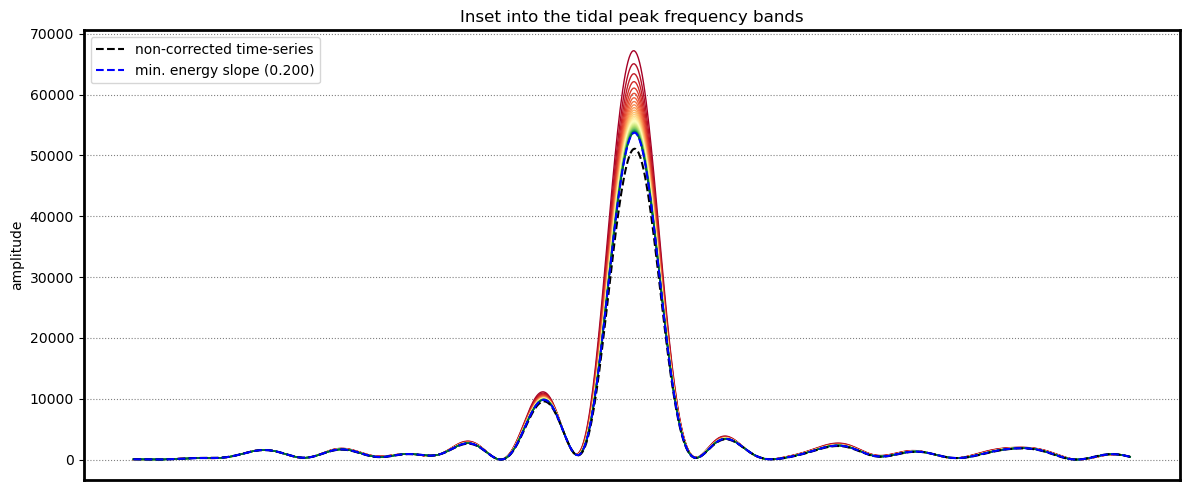

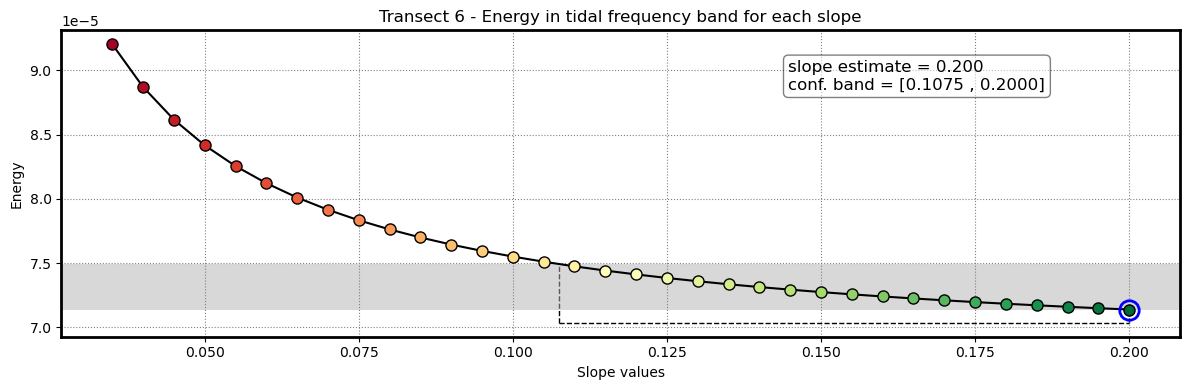

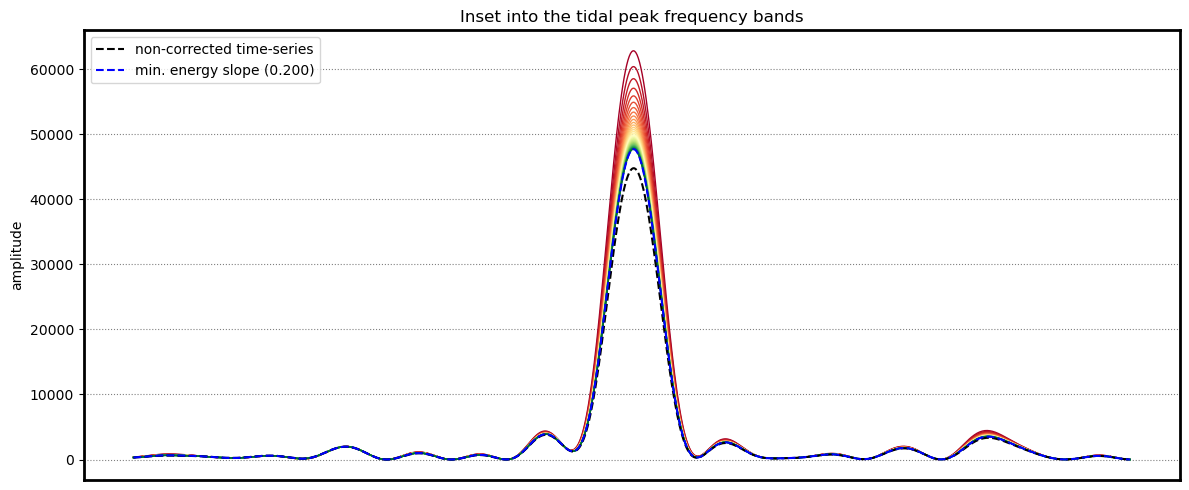

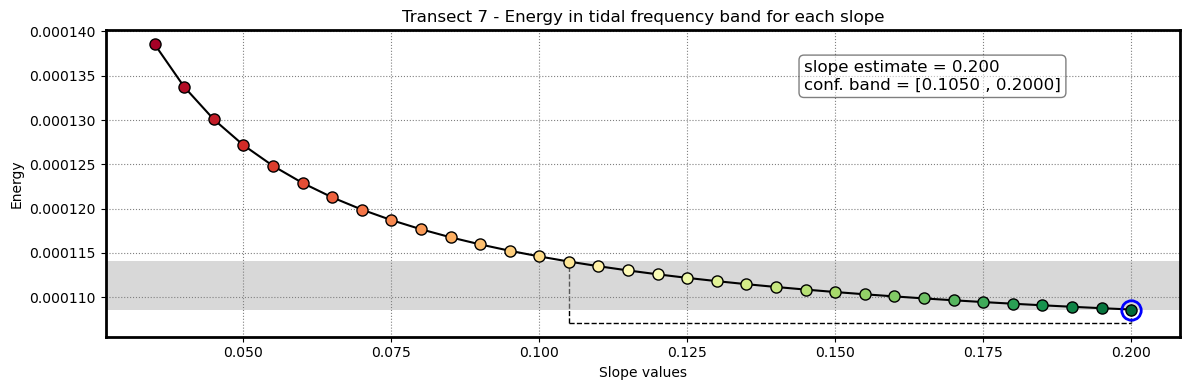

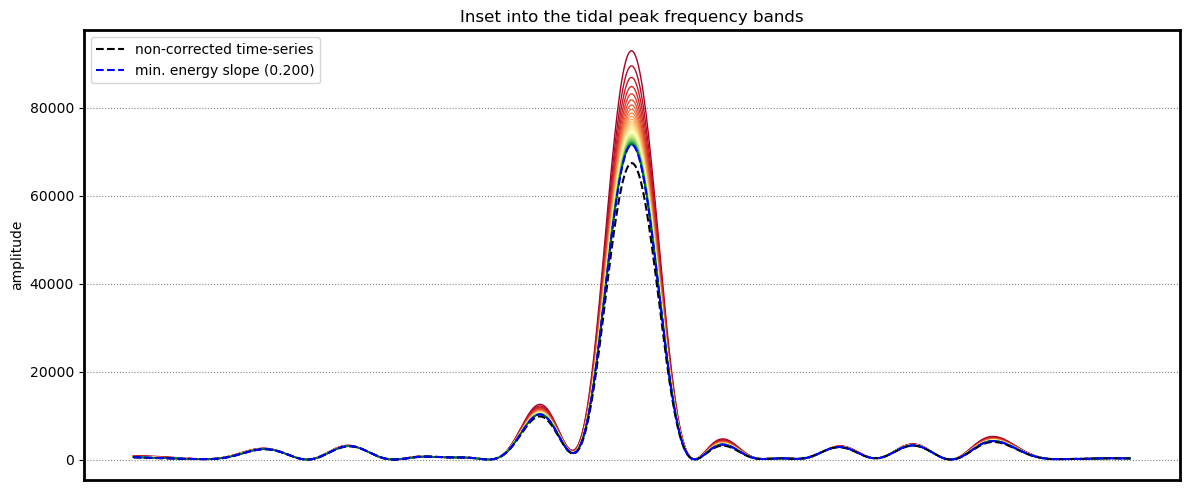

In [159]:
# estimate beach-face slopes along the transects
slope_est, cis = dict([]), dict([])
for key in cross_distance_slope.keys():
    # remove NaNs
    idx_nan = np.isnan(cross_distance_slope[key])
    dates = [dates_slope[_] for _ in np.where(~idx_nan)[0]]
    tide = tides_slope[~idx_nan]
    composite = cross_distance_slope[key][~idx_nan]
    # apply tidal correction
    tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
    # estimate beach slope
    slope_est[key],cis[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope, key)
    plt.gcf().savefig(os.path.join(fp_slopes,'2_energy_curve_%s.jpg'%key),dpi=200)
    # plot spectrums
    SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope,slope_est[key])
    plt.gcf().savefig(os.path.join(fp_slopes,'3_slope_spectrum_%s.jpg'%key),dpi=200)
    print('Beach slope at transect %s: %.3f (%.4f - %.4f)'%(key, slope_est[key], cis[key][0], cis[key][1]))
plt.show()

# FINITO SLOPE

In [160]:
print(f"Length of cross_distance[{key}]:", len(cross_distance[key]))
print("Length of correction:", len(correction))
print("Length of tides:", len(tides_sat))


Length of cross_distance[7]: 708
Length of correction: 708
Length of tides: 708


Tidally-corrected time-series of the shoreline change along the transects saved as:
/Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/transect_time_series_tidally_corrected.csv


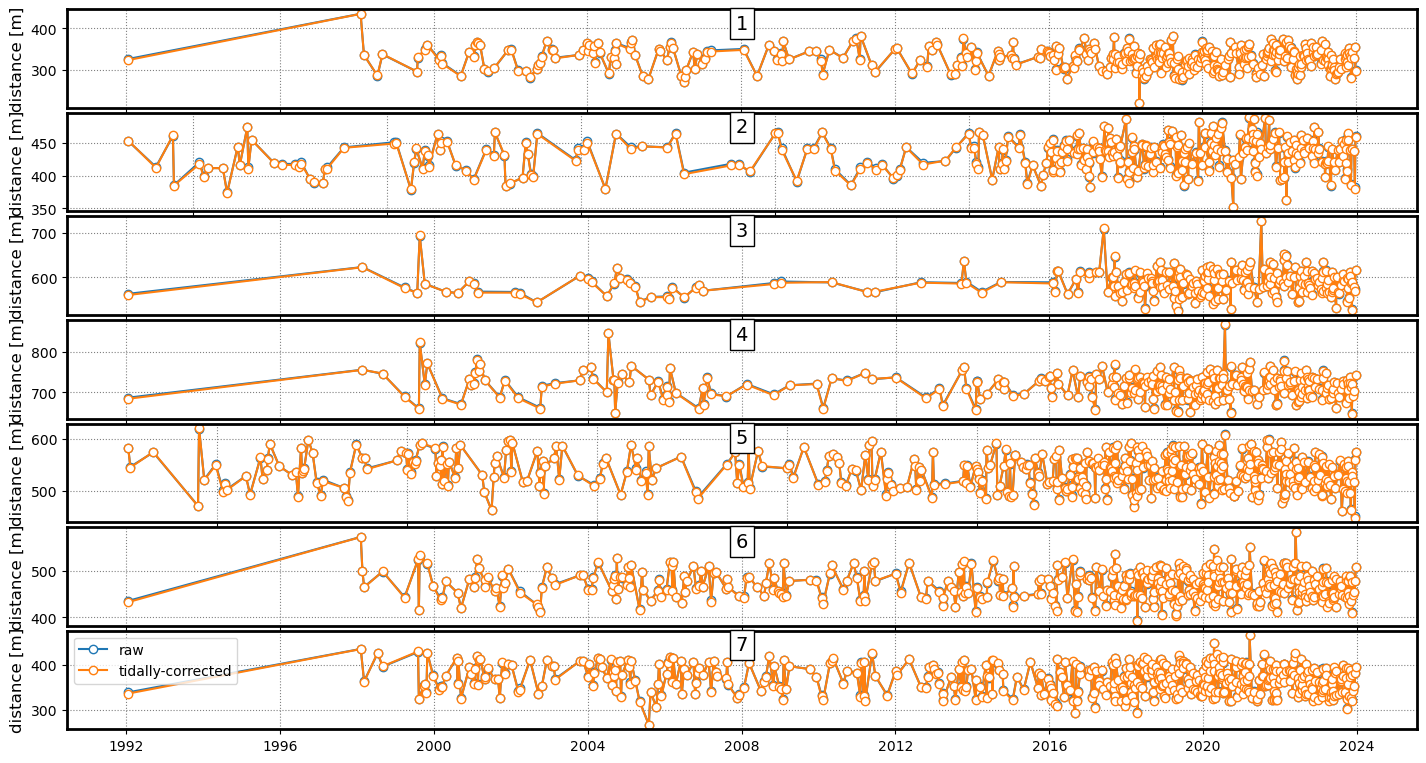

In [166]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be

beach_slope = 0.2

cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(filepath,'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(os.path.join(filepath,'%s_timeseries_corrected.jpg'%sitename),dpi=200)
plt.show()

## Time-series post-processing

Finally, we can post-process the time-series of shoreline change to remove obvious outliers and spikes in the data and average the time-series over different time-frames (seasonally or monthly).

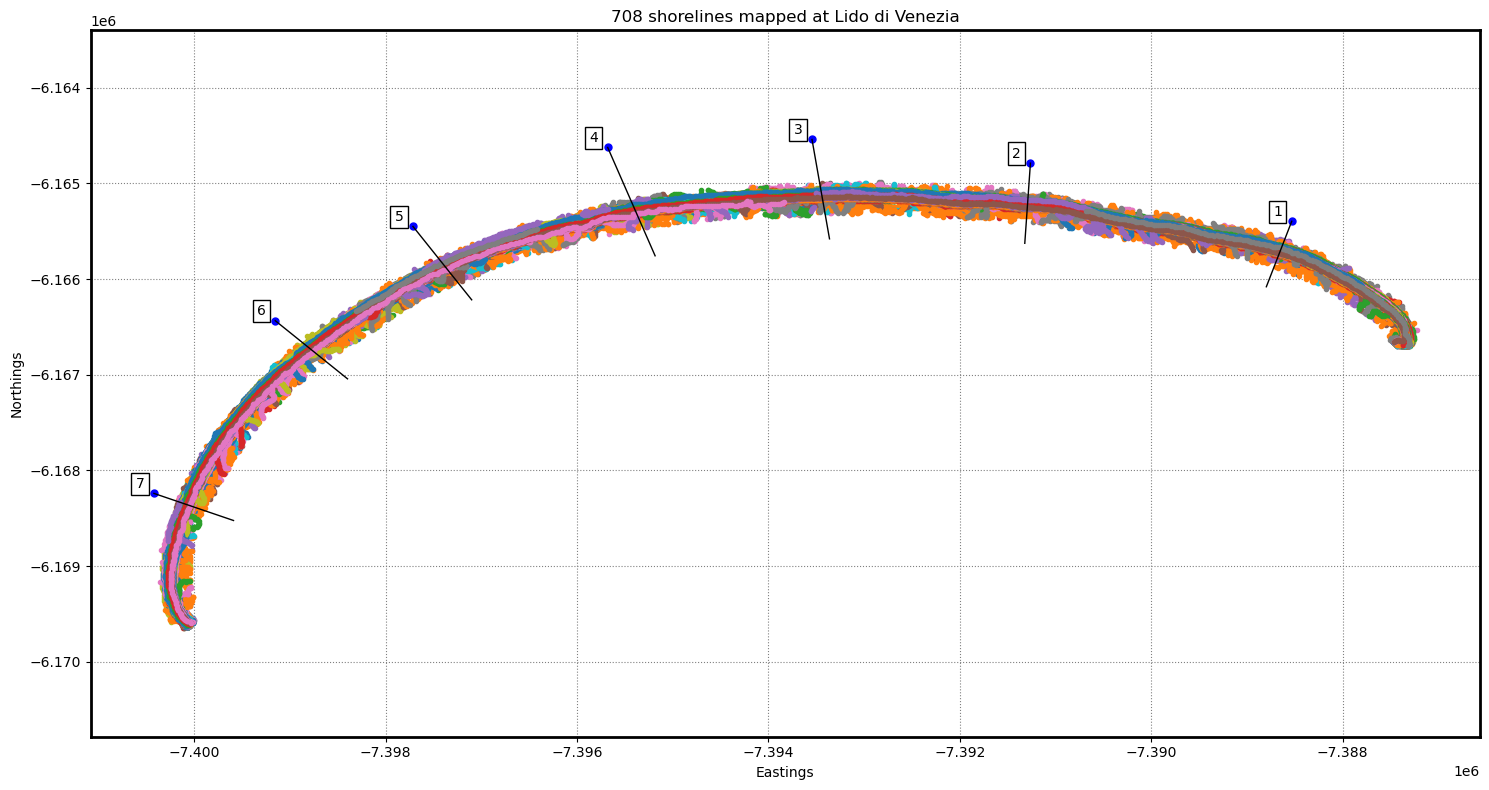

In [175]:
# plot the mapped shorelines
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title('%d shorelines mapped at Lido di Venezia'%len(output['shorelines']))
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
             va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

# load long time-series
filename_ts = os.path.join(os.getcwd(),'Data',sitename,'transect_time_series_tidally_corrected.csv')
df = pd.read_csv(filename_ts, parse_dates=['dates'])
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict([])
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

### Despiking the time-series

The tidally-corrected time-series of shoreline change obtained with the steps above may still contain some outliers (from cloud shadows, false detections etc). The function `SDS_transects.reject_outliers()` was developed to remove obvious outliers in the time-series, by removing the points that do not make physical sense in a shoreline change setting. 

For example, the shoreline can experience rapid erosion after a large storm, but it will then take time to recover and return to its previous state. Therefore, if the shoreline erodes/accretes suddenly of a significant amount (`max_cross_change`) and then immediately returns to its previous state, this spike does not make any physical sense and can be considered an outlier. Additionally, this function also checks that the Otsu thresholds used to map the shoreline are within the typical range defined by `otsu_threshold`, with values outside this range identified as outliers.

****1  - outliers removed: 135
******2  - outliers removed: 144
****3  - outliers removed: 118
******4  - outliers removed: 168
********5  - outliers removed: 263
********6  - outliers removed: 260
******7  - outliers removed: 280


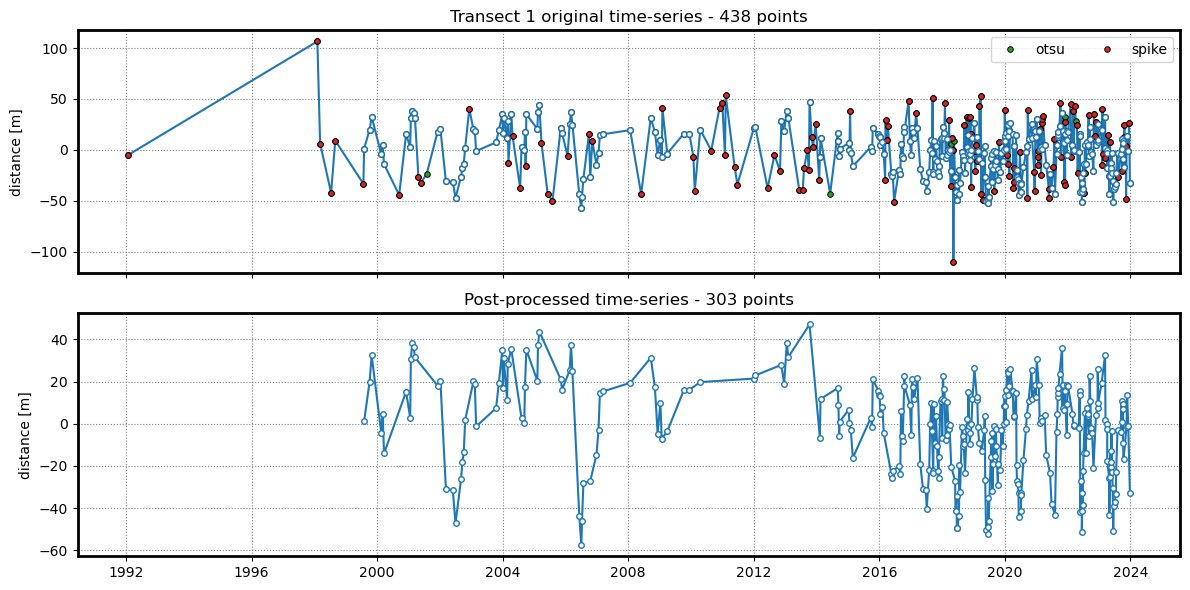

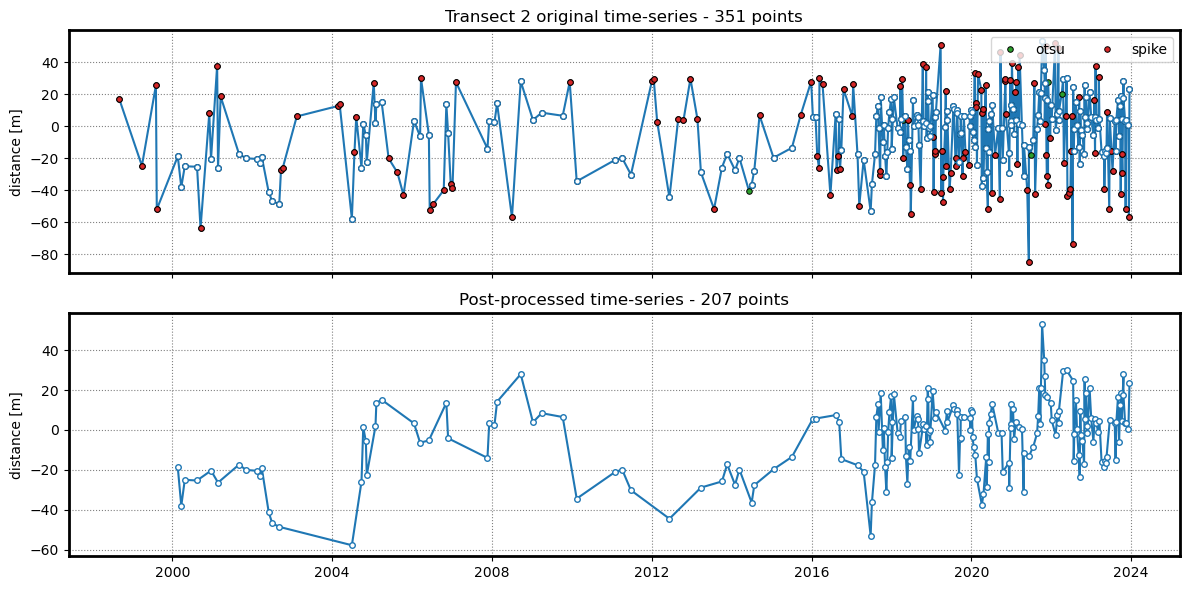

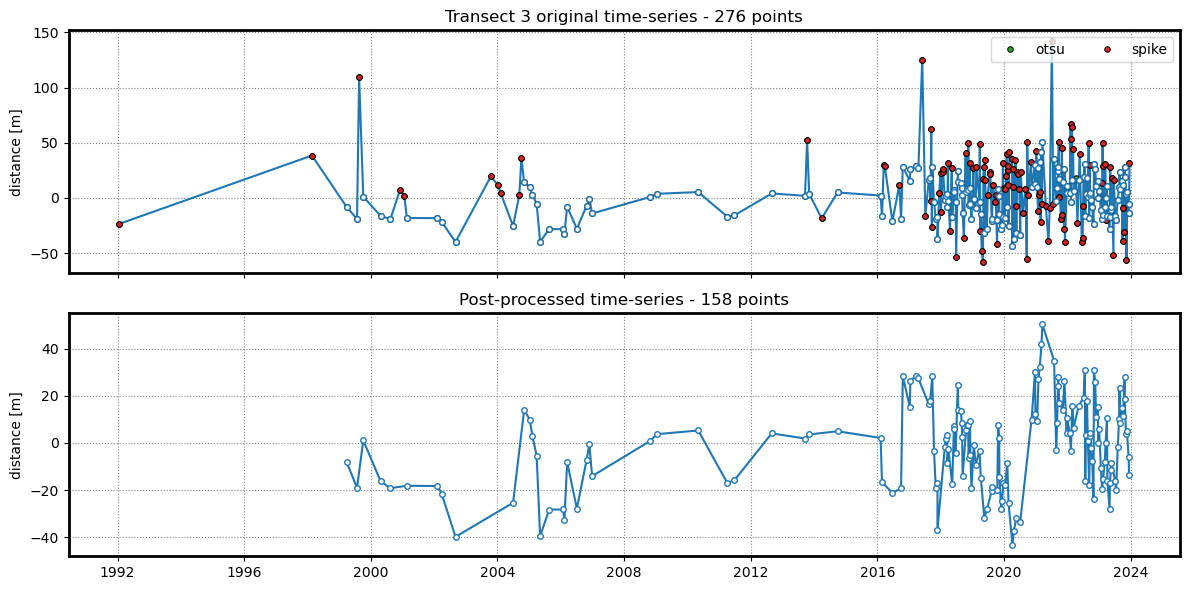

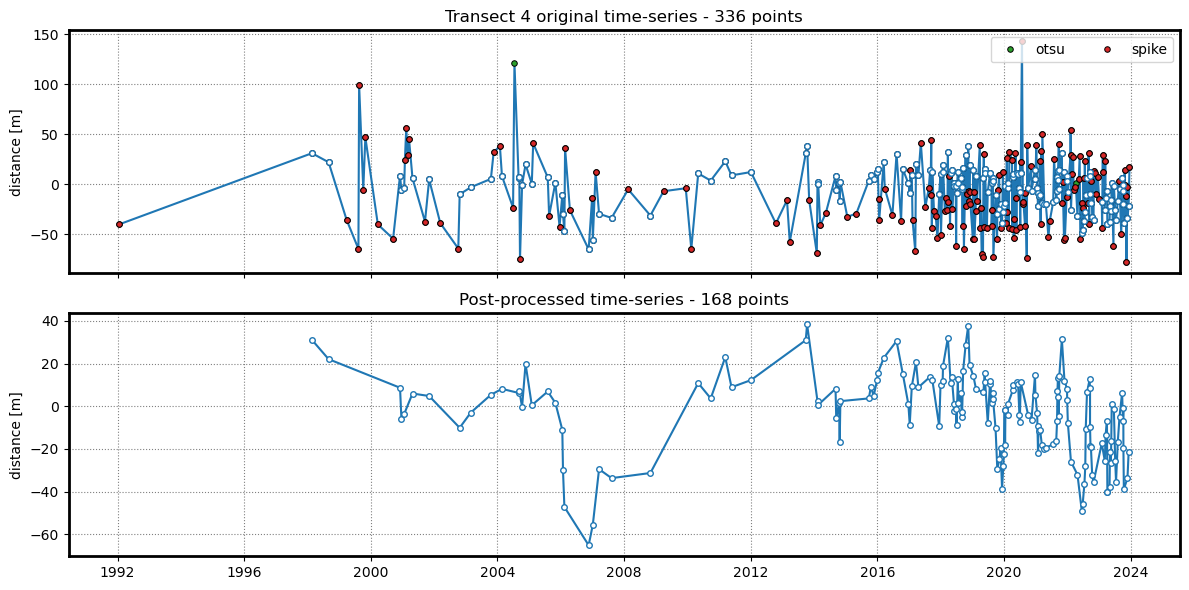

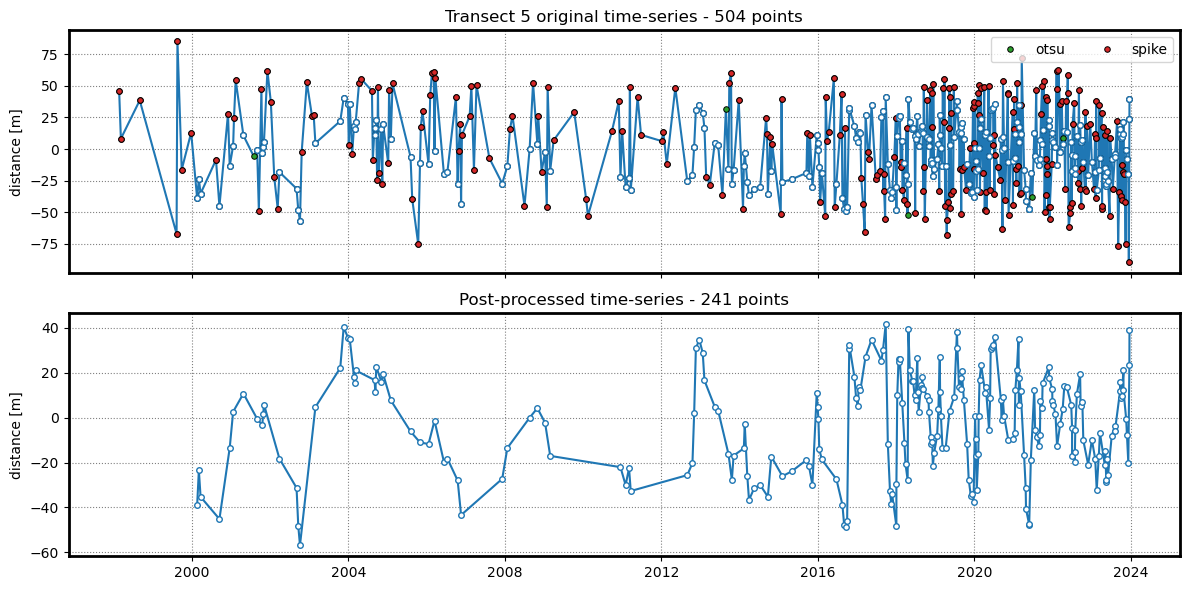

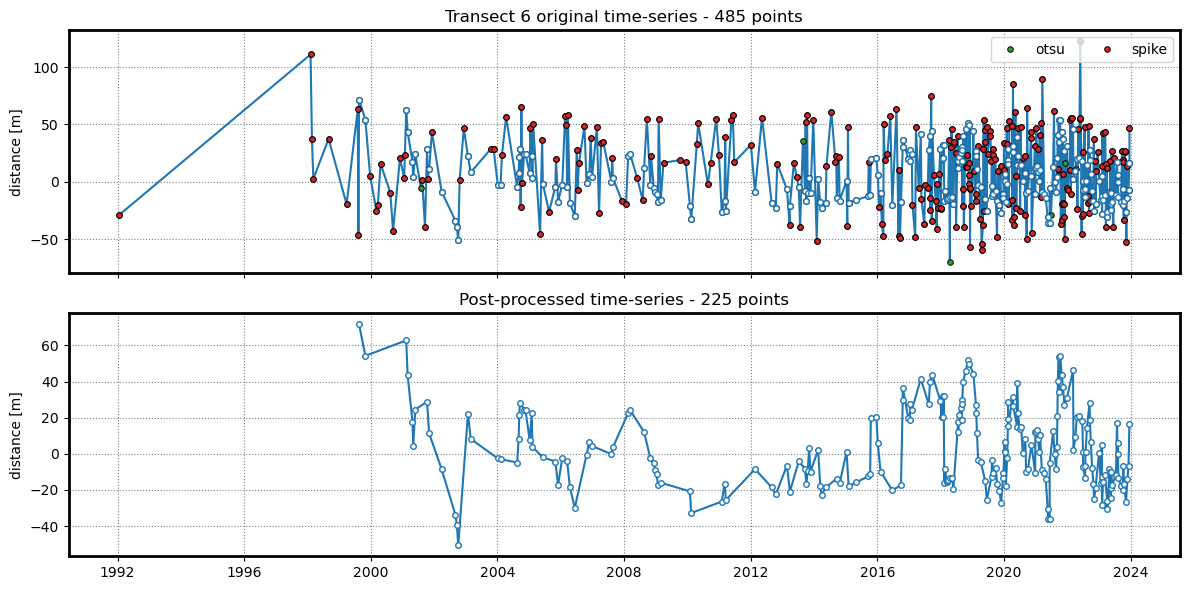

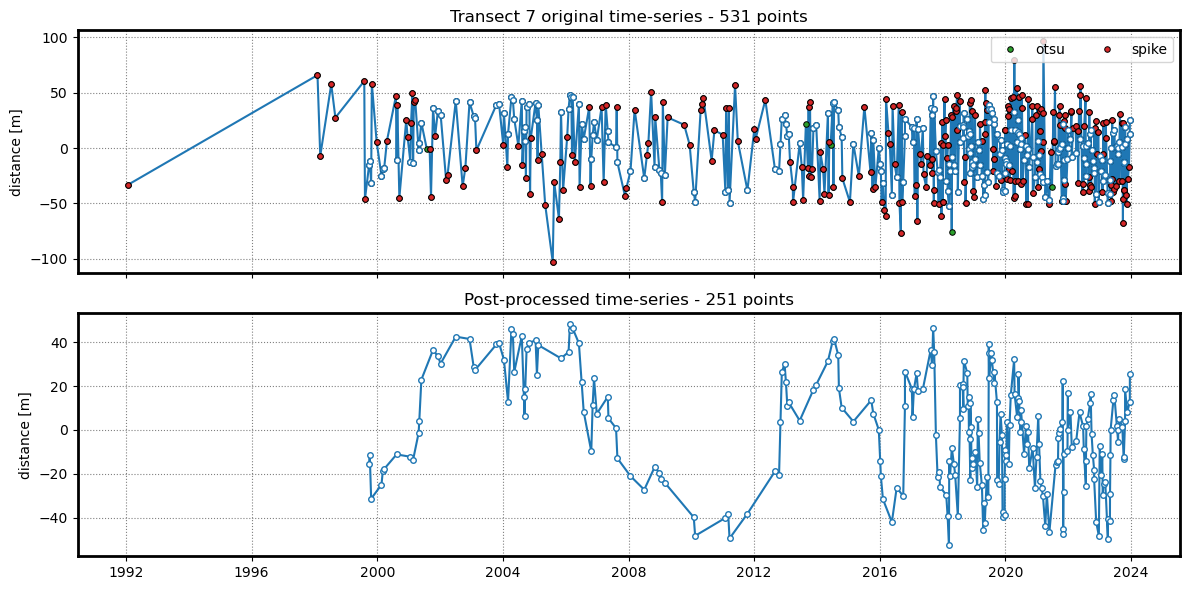

In [176]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   20,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)
plt.show()

We can also plot the Otsu threholds for the shorelines mapped at this site to see if there are any obvious outliers and adjust the values of `otsu_threshold`.

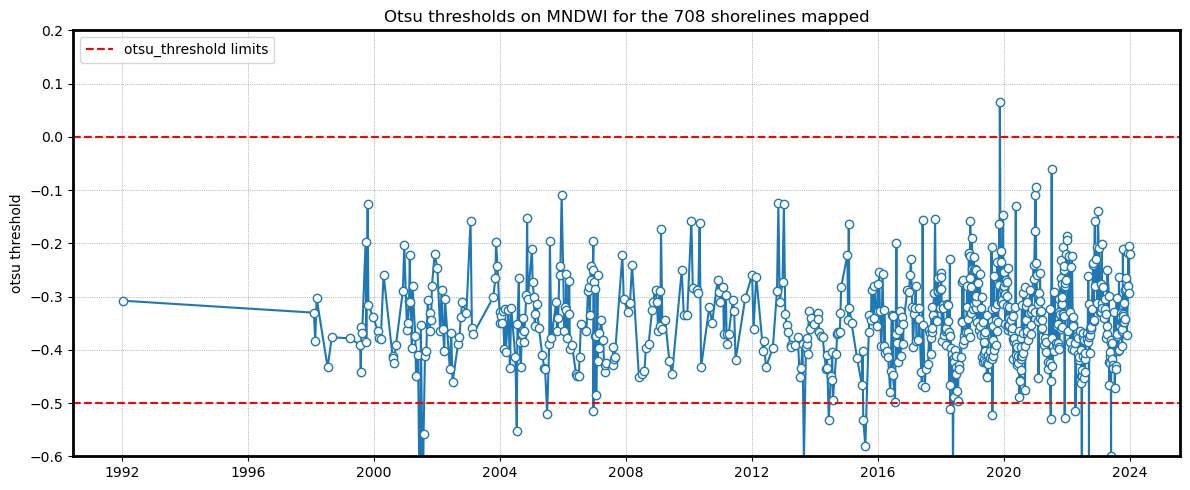

In [177]:
# plot Otsu thresholds for the mapped shorelines
fig,ax = plt.subplots(1,1,figsize=[12,5],tight_layout=True)
ax.grid(which='major',ls=':',lw=0.5,c='0.5')
ax.plot(output['dates'],output['MNDWI_threshold'],'o-',mfc='w')
ax.axhline(y=-0.5,ls='--',c='r',label='otsu_threshold limits')
ax.axhline(y=0,ls='--',c='r')
ax.set(title='Otsu thresholds on MNDWI for the %d shorelines mapped'%len(output['shorelines']),
       ylim=[-0.6,0.2],ylabel='otsu threshold')
ax.legend(loc='upper left')
fig.savefig(os.path.join(filepath,'%s_otsu_threhsolds.jpg'%sitename), dpi=200)
plt.show()

### Seasonal averaging and long-term trends

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.seasonal_average()` and calculate the long-term trend with `SDS_transects.calculate_trend()`.

Outputs will be saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/jpg_files/seasonal_timeseries


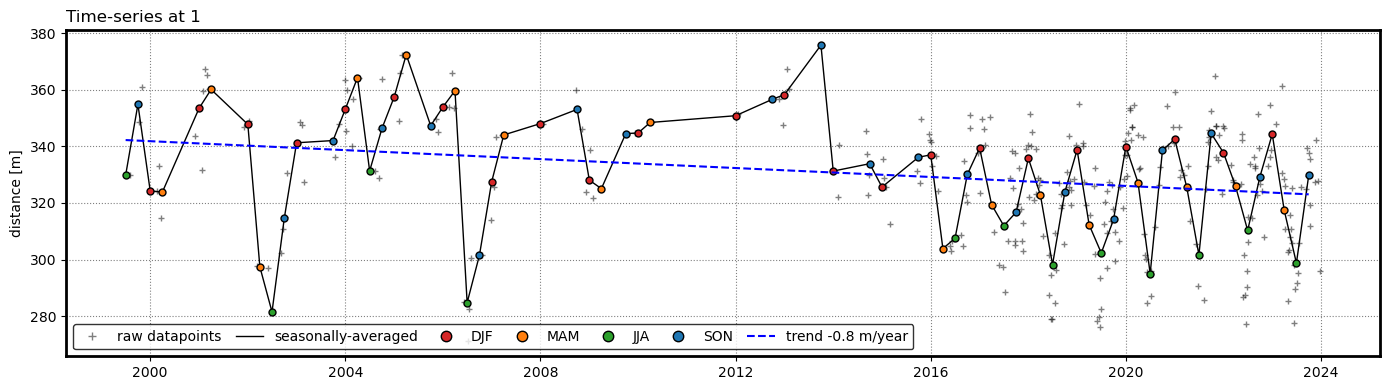

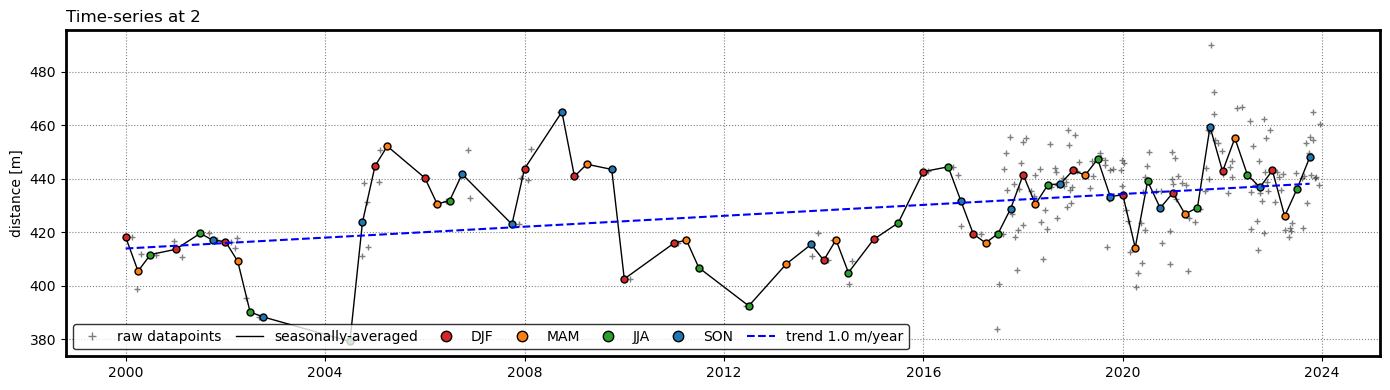

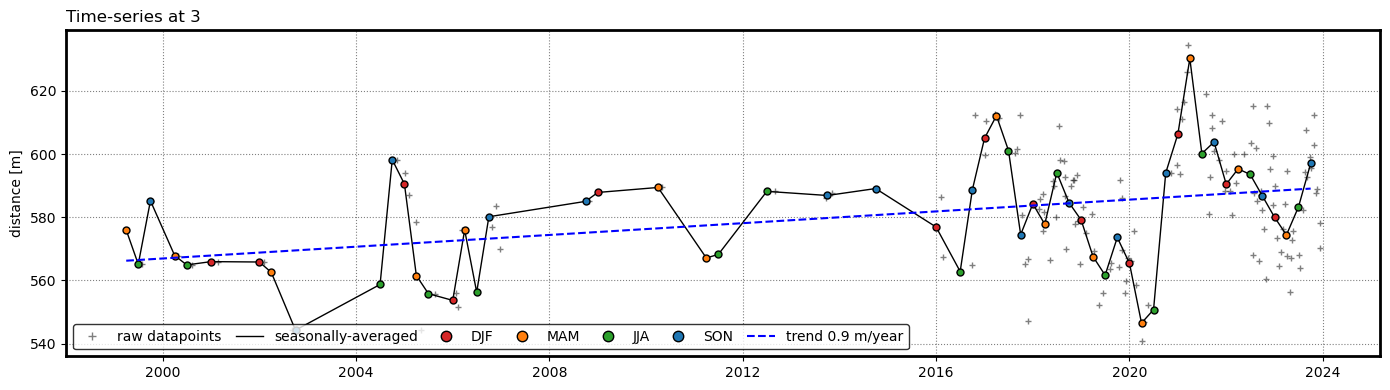

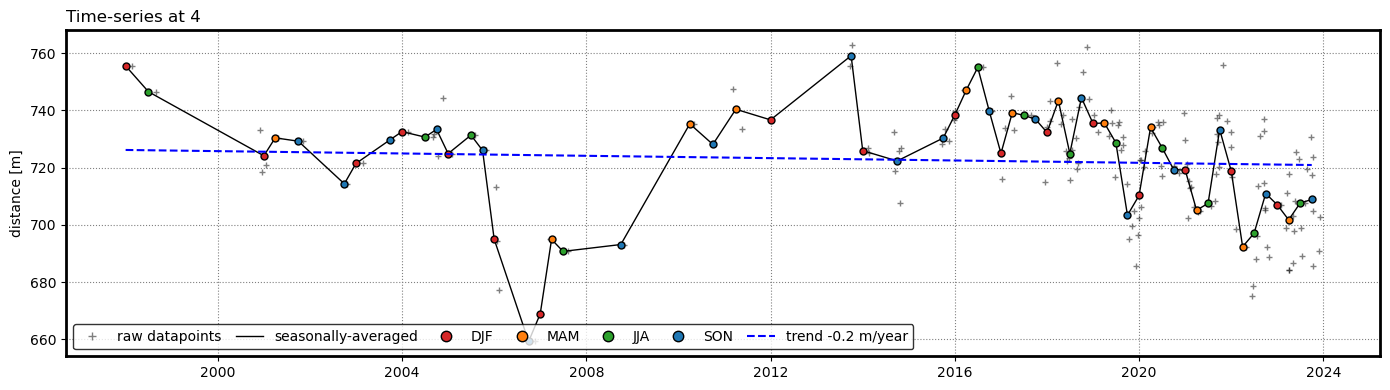

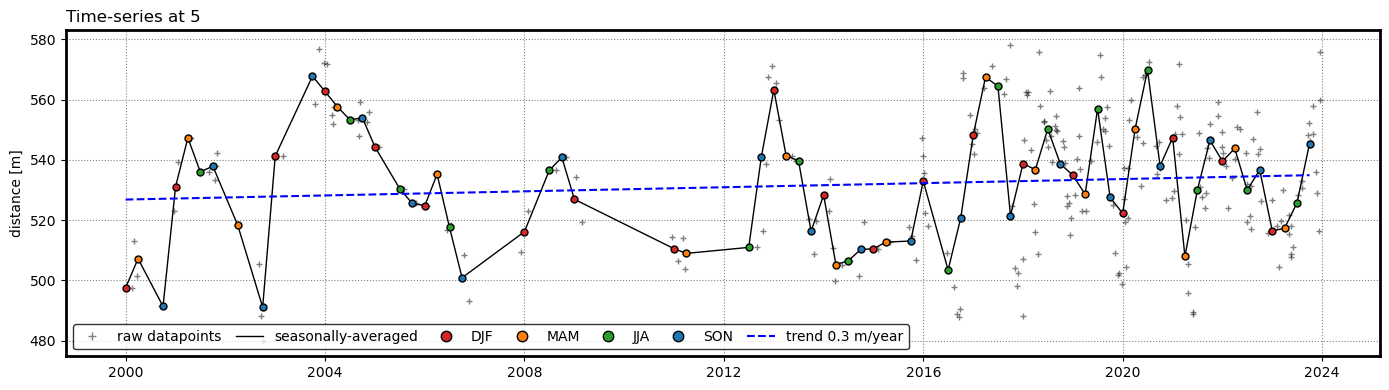

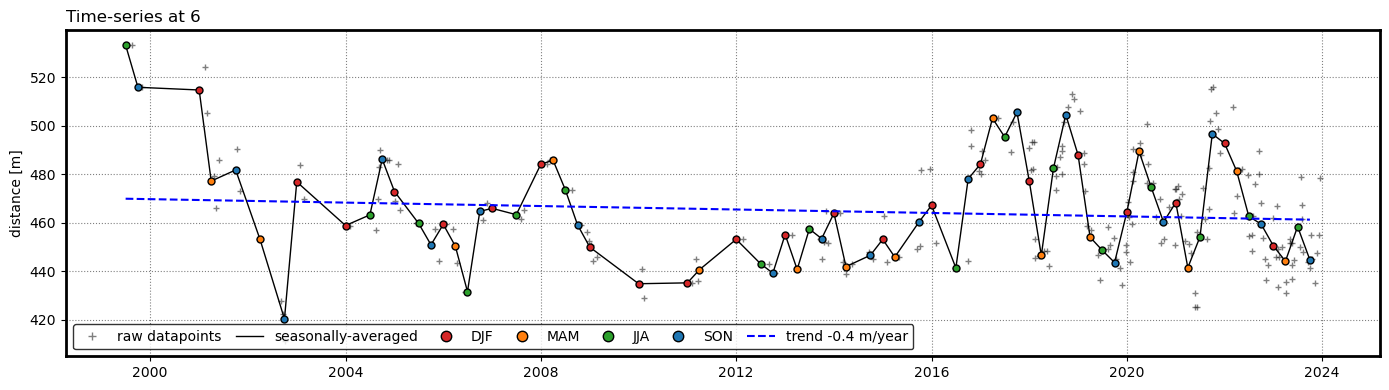

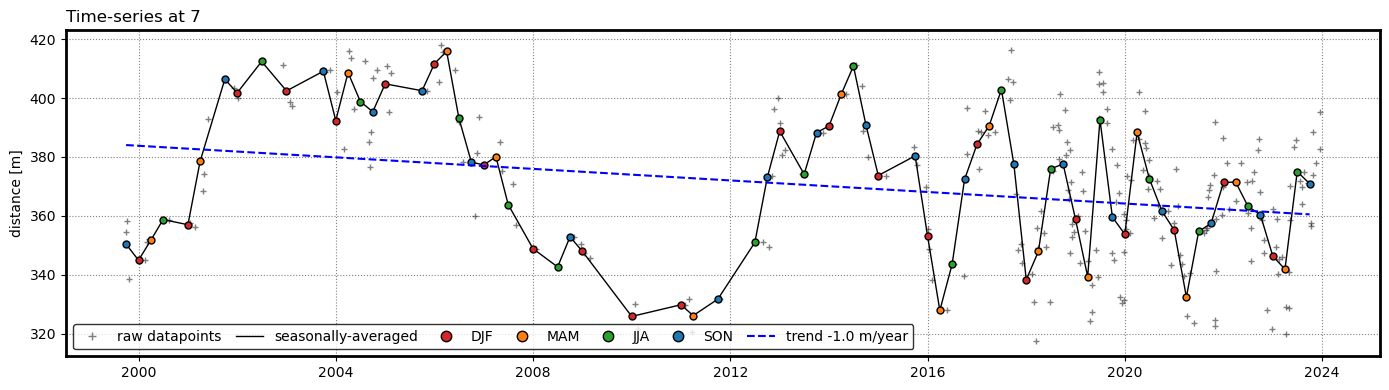

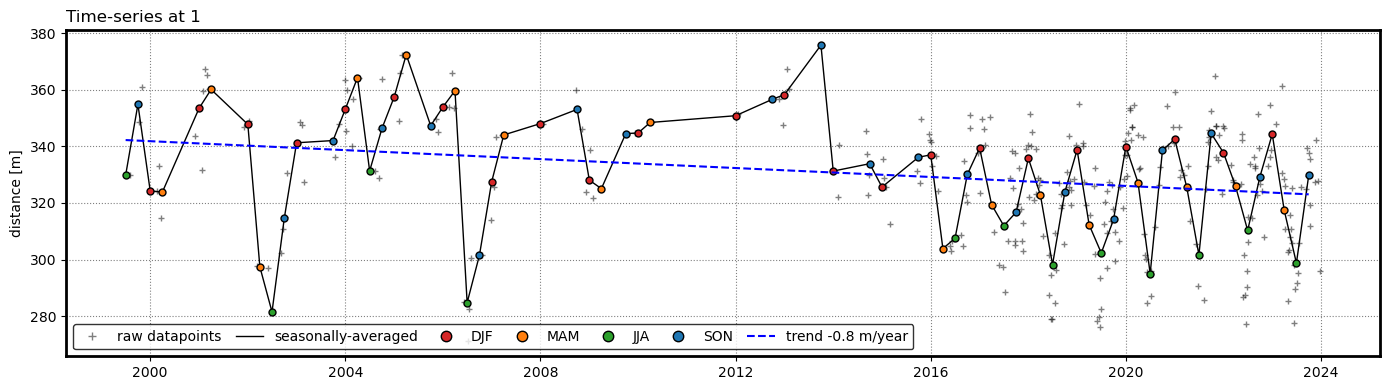

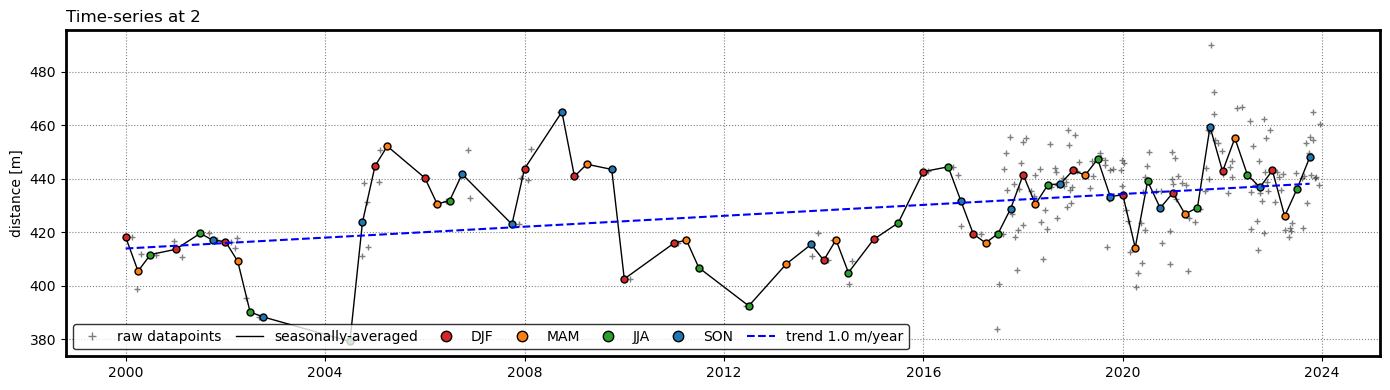

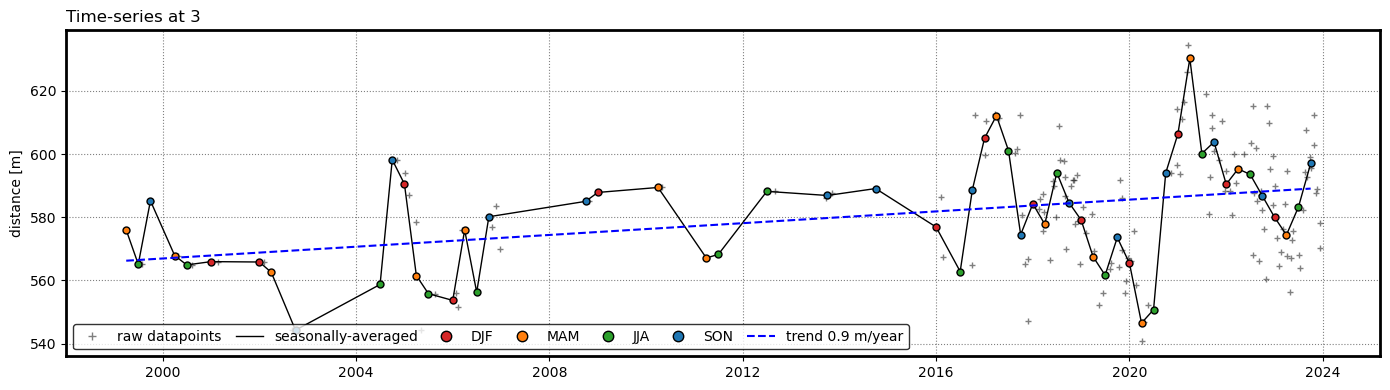

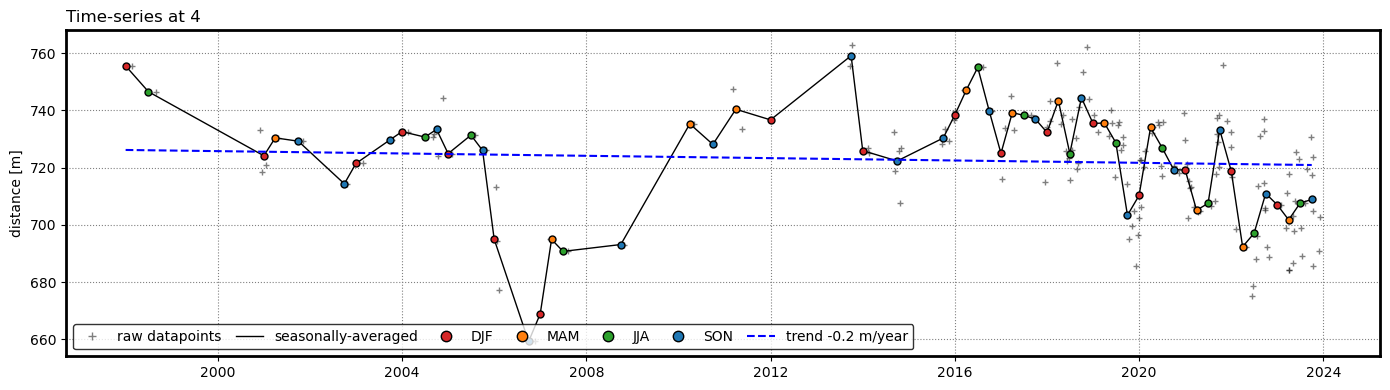

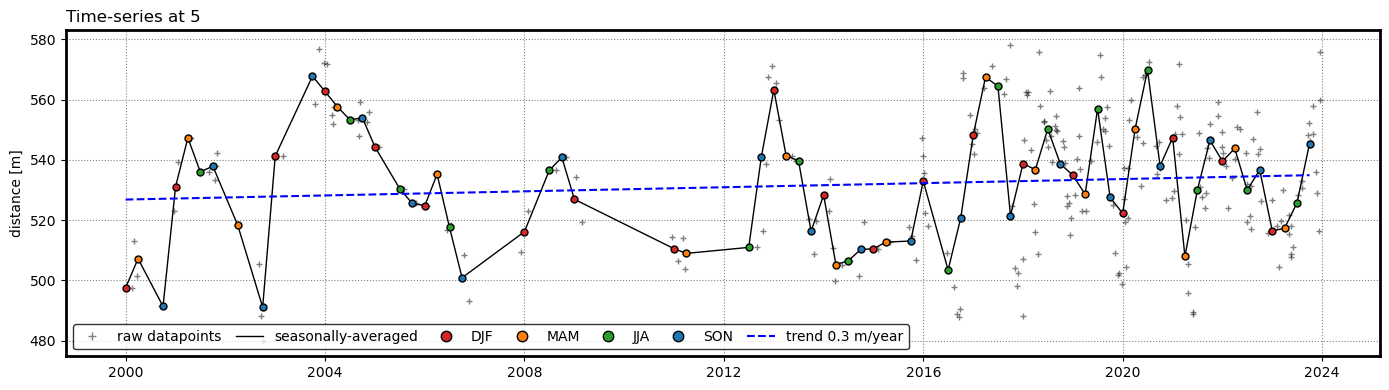

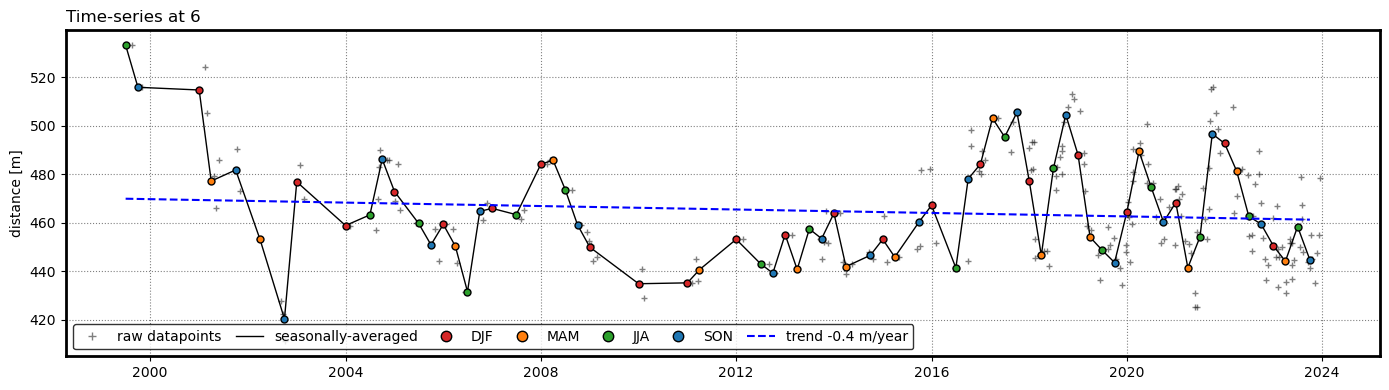

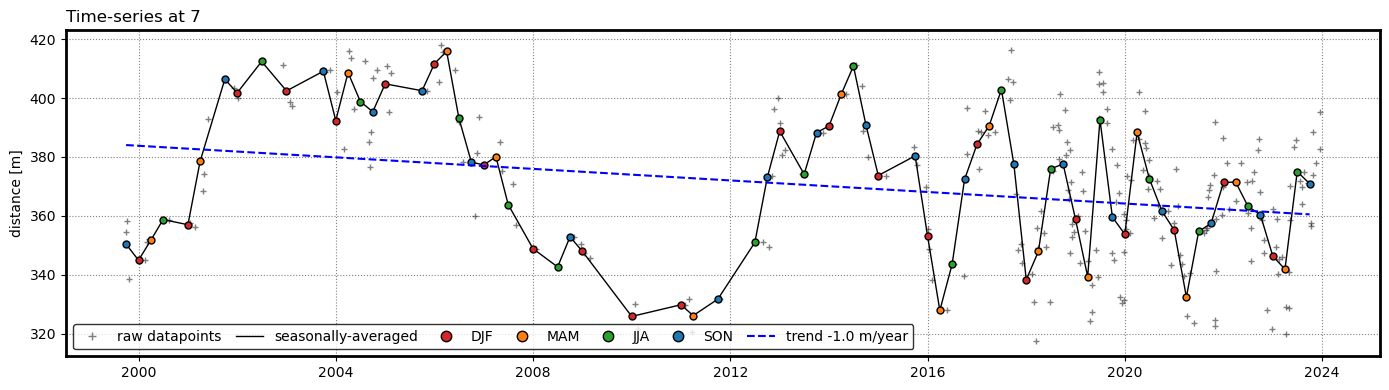

In [179]:
fp_seasonal = os.path.join(filepath,'jpg_files','seasonal_timeseries')
if not os.path.exists(fp_seasonal): os.makedirs(fp_seasonal)
print('Outputs will be saved in %s'%fp_seasonal)
season_colors = {'DJF':'C3', 'MAM':'C1', 'JJA':'C2', 'SON':'C0'}
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline seasonal averages (DJF, MAM, JJA, SON)
    dict_seas, dates_seas, chainage_seas, list_seas = SDS_transects.seasonal_average(dates_nonan, chainage)
    
    # calculate long-term trend
    trend, y =  SDS_transects.calculate_trend(dates_seas, chainage_seas)
    
    # plot seasonal averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_seas, chainage_seas, '-', lw=1, color='k', mfc='w', ms=4, label='seasonally-averaged')
    for k,seas in enumerate(dict_seas.keys()):
        ax.plot(dict_seas[seas]['dates'], dict_seas[seas]['chainages'],
                 'o', mec='k', color=season_colors[seas], label=seas,ms=5)
    ax.plot(dates_seas,y,'--',color='b', label='trend %.1f m/year'%trend)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)
    fig.savefig(os.path.join(fp_seasonal,'%s_timeseries_seasonal.jpg'%sitename), dpi=200)

plt.show()

### Monthly averages

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.monthly_average()` and plot them.

Outputs will be saved in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Bahia_Laura/jpg_files/monthly_timeseries


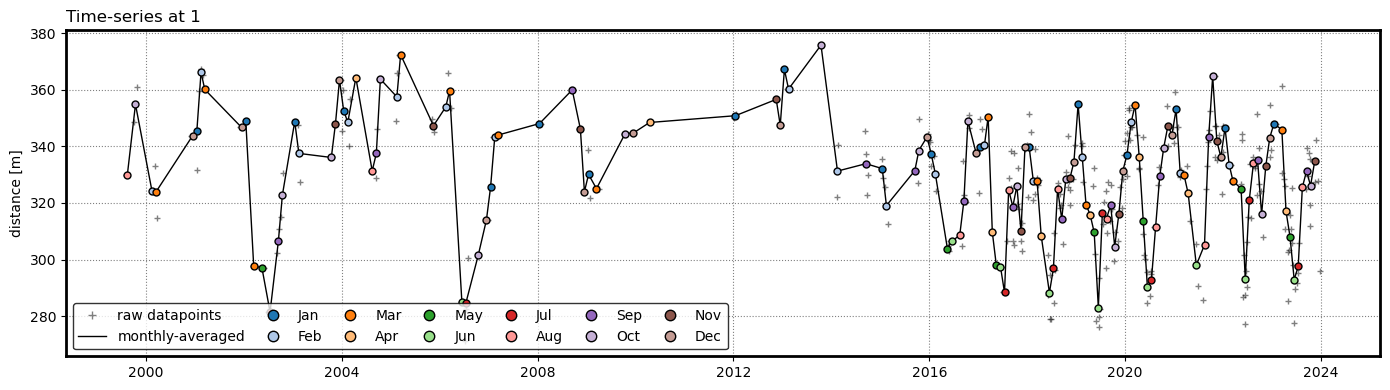

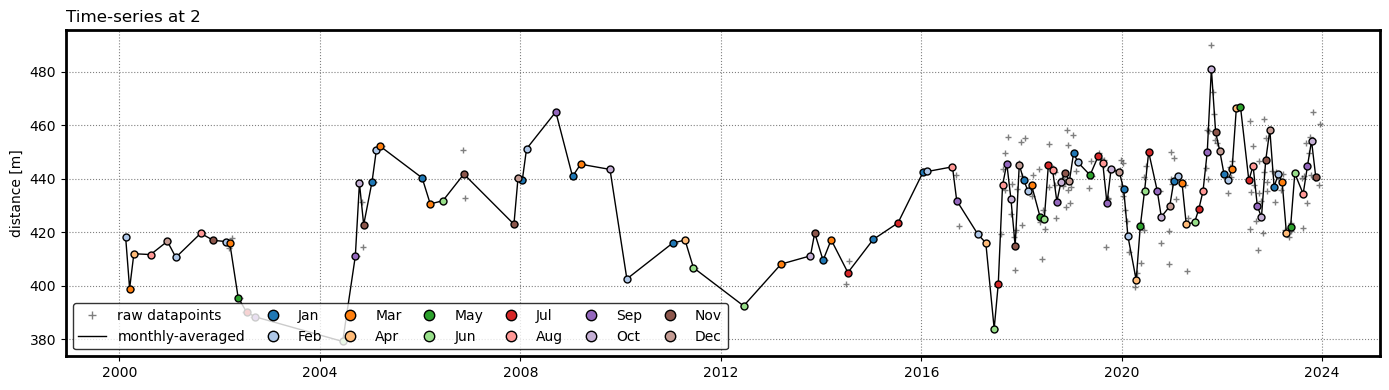

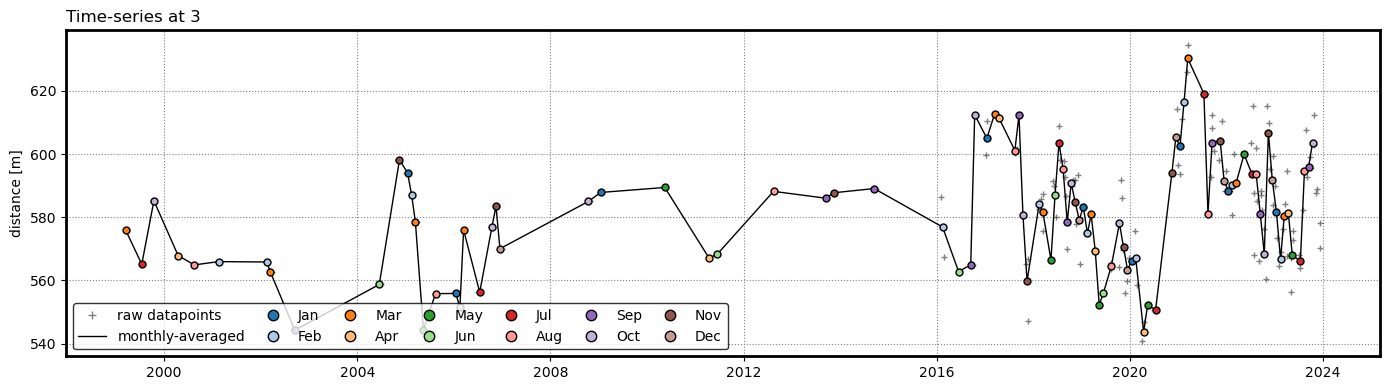

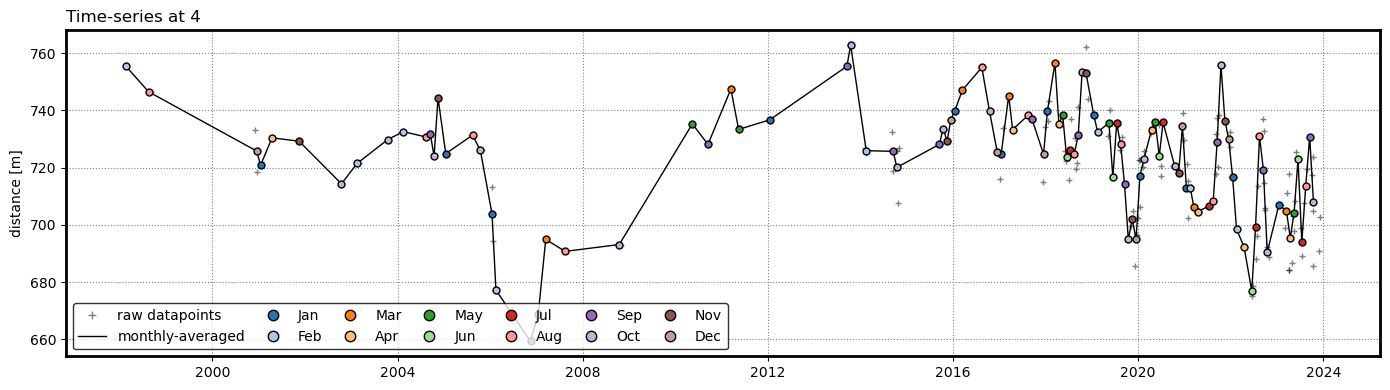

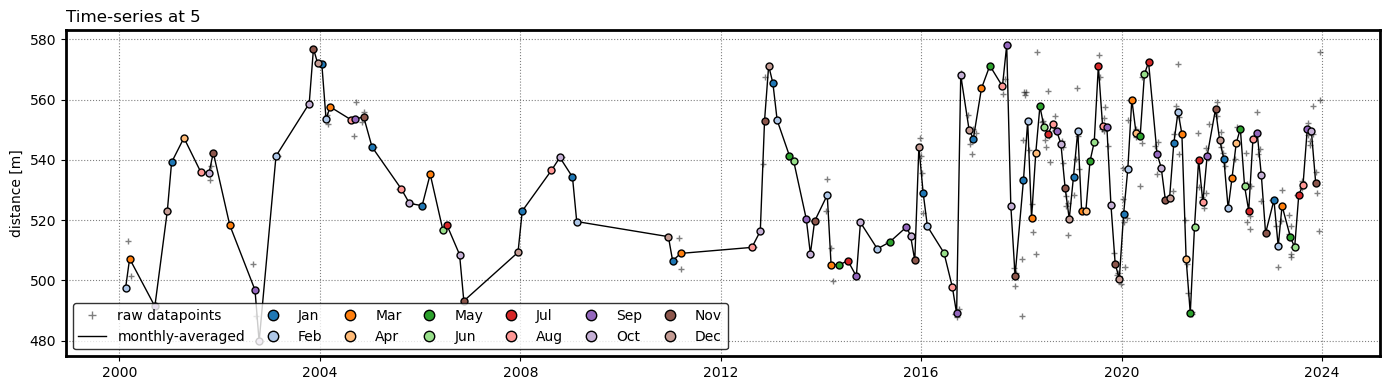

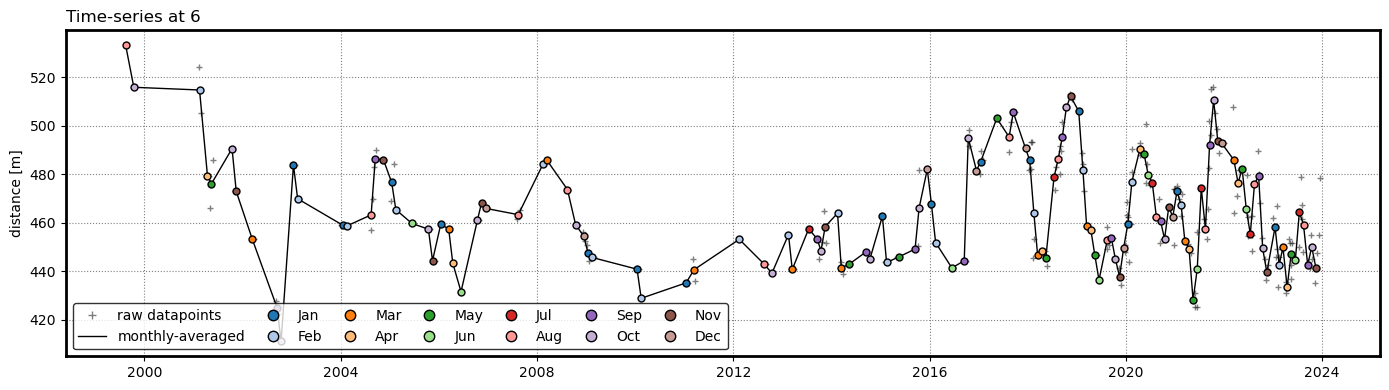

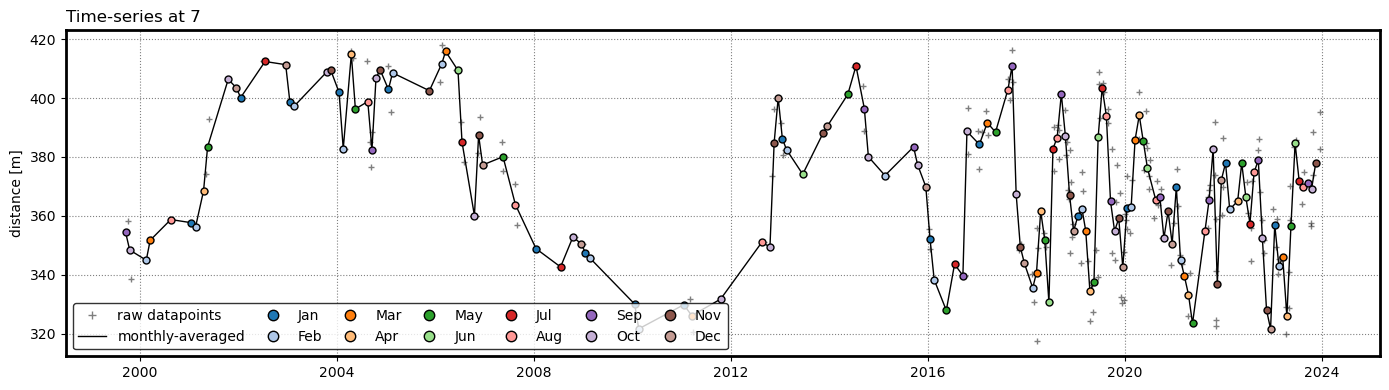

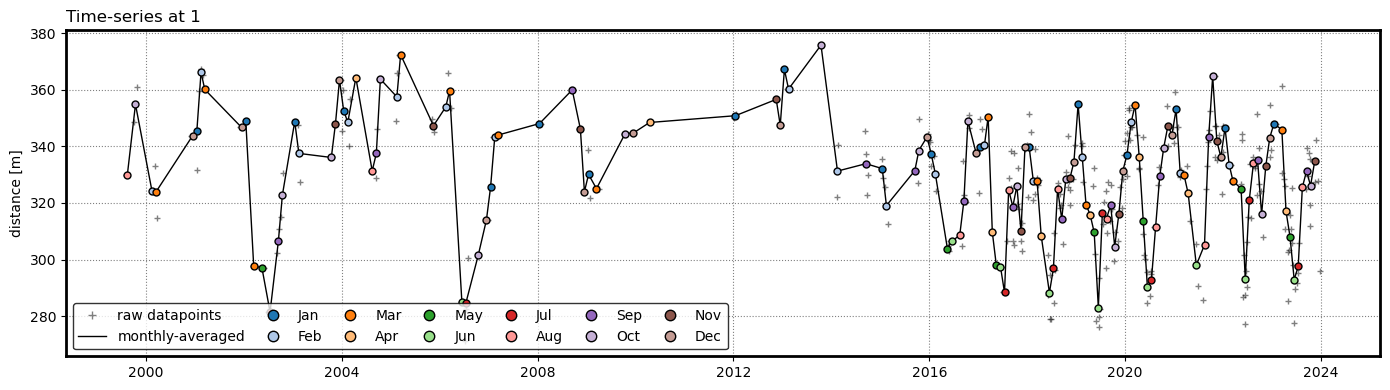

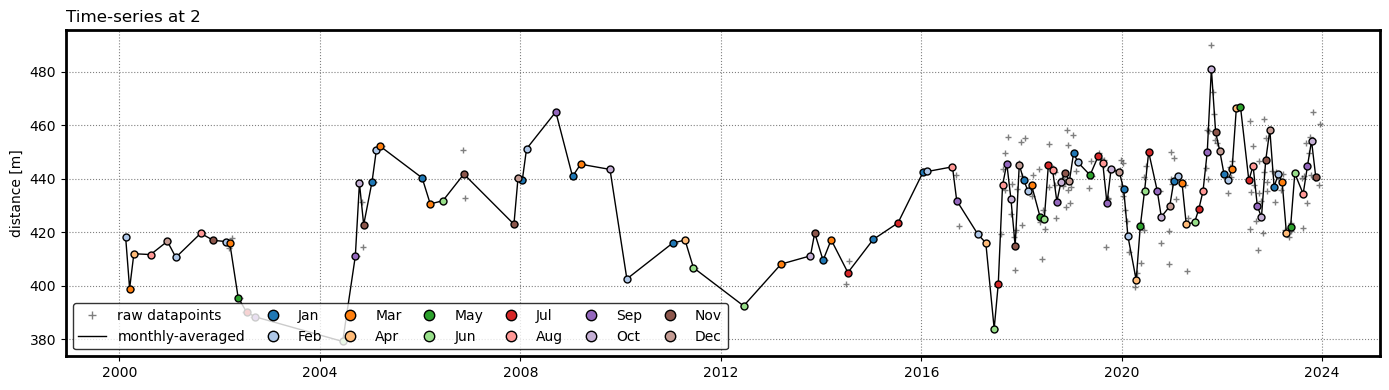

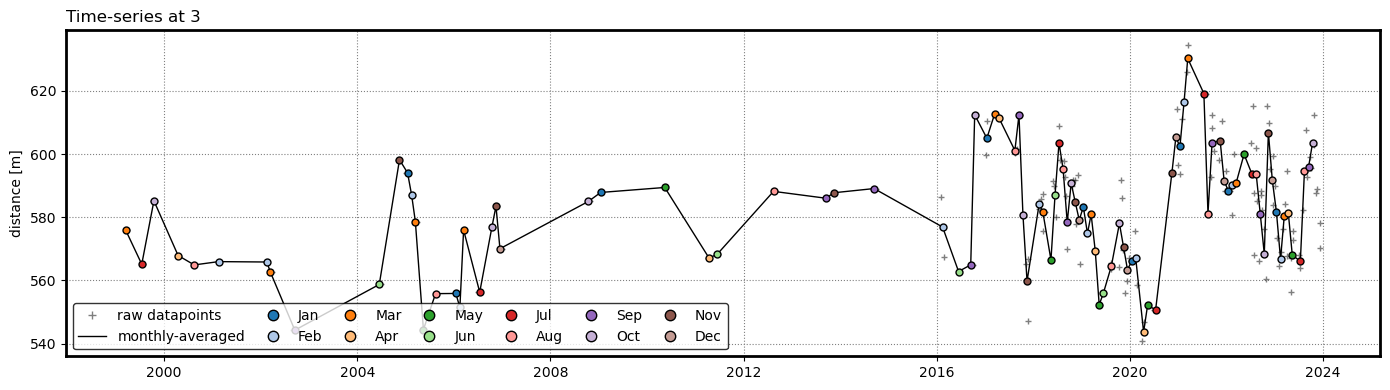

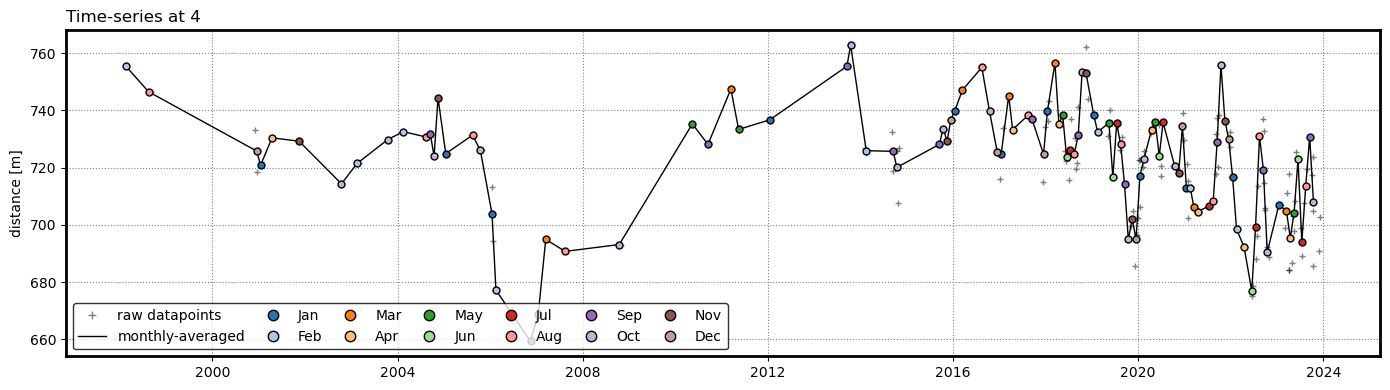

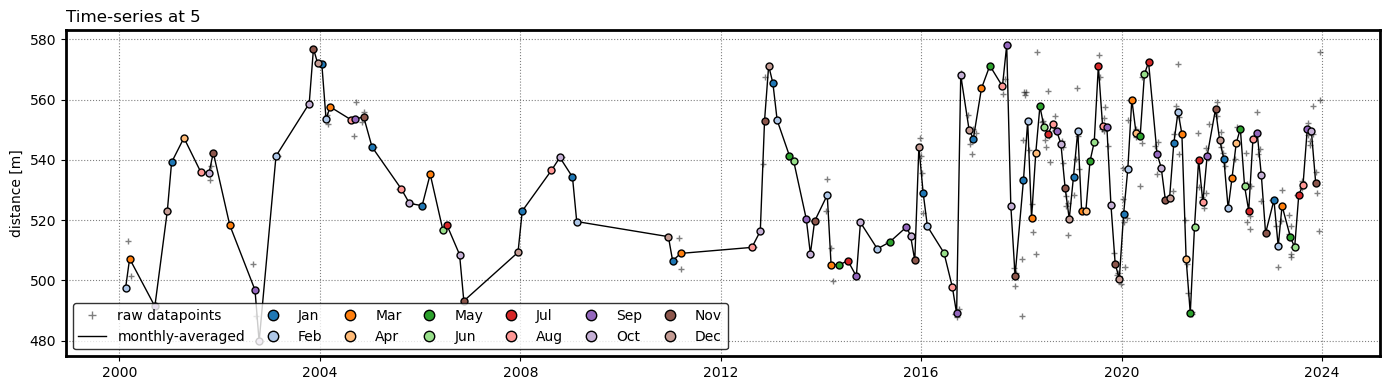

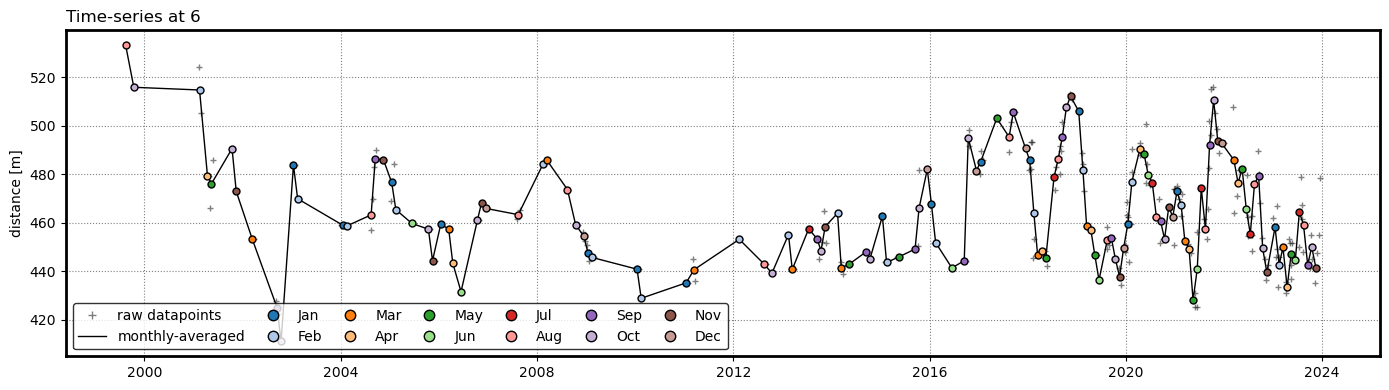

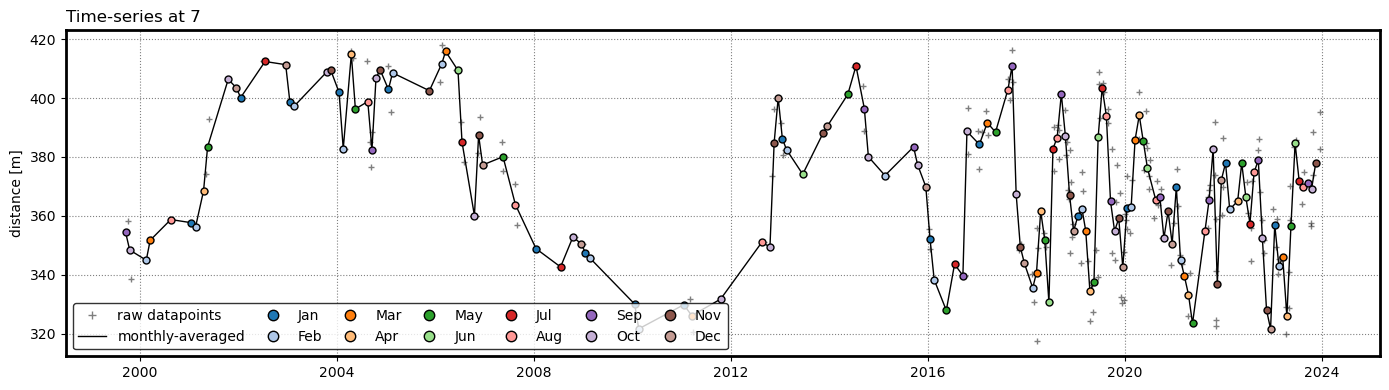

In [181]:
fp_monthly = os.path.join(filepath,'jpg_files','monthly_timeseries')
if not os.path.exists(fp_monthly): os.makedirs(fp_monthly)
print('Outputs will be saved in %s'%fp_monthly)
month_colors = plt.get_cmap('tab20')
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline monthly averages
    dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
    
    # plot monthly averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_month, chainage_month, '-', lw=1, color='k', mfc='w', ms=4, label='monthly-averaged')
    for k,month in enumerate(dict_month.keys()):
        ax.plot(dict_month[month]['dates'], dict_month[month]['chainages'],
                 'o', mec='k', color=month_colors(k), label=month,ms=5)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)
    fig.savefig(os.path.join(fp_monthly,'%s_timeseries_monthly.jpg'%sitename), dpi=200)

plt.show()